In [1]:
%load_ext autoreload

In [2]:
%autoreload
import utilhysplit

/hysplit-users/alicec/anaconda3/envs/paris/lib/python3.8/site-packages/pyresample/bilinear/__init__.py:49: UserWarning: XArray and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray and/or zarr not found, XArrayBilinearResampler won't be available.")


In [3]:
import geopandas

In [4]:
from utilhysplit import parutils

In [5]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from monetio.models import hysplit

In [6]:
from utilvolc import volcat
import utilvolc.ash_inverse as ai
import utilvolc.ash_eval as ae
from utilvolc import volcMER
from utilhysplit.evaluation import ensemble_tools
from utilhysplit.evaluation import plume_stat
import cases

In [7]:
%autoreload
case = cases.runM()
print(case)
tag = case.vhash['tag']
tdir = case.vhash['tdir']
tname = case.vhash['tname']
configdir= case.vhash['configdir']
configfile = case.vhash['configfile']
vdir = case.vhash['vdir']
vid = case.vhash['vid']
gdir = case.vhash['gdir']
graphicstype = case.vhash['graphicstype']
vloc = case.vhash['vloc']

vloc : [160.587, 55.978]
tag : M
tdir : ../RunM/RunM_1_2_3_4_TF
tname : RunM4.nc
configdir : ../RunM
configfile : config.invbezyM.txt
vdir : ../data/volcat/
vid : v300250
gdir : ./graphics/
graphicstype : png



In [10]:
%autoreload
aeval = ae.AshEval(tdir,tname,vdir,vid,configdir=configdir,configfile=configfile)

In [11]:
%autoreload
#time list to prepare.
# start with one hour after eruption. 21:00-22:00
dlist = []
sdate = datetime.datetime(2020,10,21,22,0)
#sdate = datetime.datetime(2020,10,22,12,0)
dt = datetime.timedelta(hours=1)
for iii in np.arange(1,16):
    drange = [sdate, sdate+dt]
    dlist.append(drange)
    sdate += dt
print(dlist[0])
print(dlist[-1])

[datetime.datetime(2020, 10, 21, 22, 0), datetime.datetime(2020, 10, 21, 23, 0)]
[datetime.datetime(2020, 10, 22, 12, 0), datetime.datetime(2020, 10, 22, 13, 0)]


In [12]:
'mult' in aeval.cdump.attrs

False

In [13]:
%autoreload
# For the cylindrical source change the MER.
if 'mult' in aeval.cdump.attrs:
    xmult = aeval.cdump.mult
    print('{:2e}'.format(xmult))
    # convert unit mass using the 15000 kg/s from volcat.
    from utilvolc import volcMER
    cmult = volcMER.MER2unit(1.5e4,1)
    print('Using 15000 kg/s: unit mass =  {:2e} g/hr'.format(cmult[0]))
    cmult = cmult[0] 
    # divide by the old conversion factor and multiply by the new one.
    # Note that this does not change the cdump attribute but only affects output.
    aeval.set_concmult(cmult/xmult)
else:
    aeval.set_concmult(1)

In [14]:
# time averages observations
# matches observations and model forecast to the same domain.
# these are stored in dictionaries.
%autoreload
d1 = datetime.datetime(2020,10,22,1)
d2 = datetime.datetime(2020,10,22,2)
for drange in dlist:
    print(drange)
    aeval.prepare_one_time(drange)

[datetime.datetime(2020, 10, 21, 22, 0), datetime.datetime(2020, 10, 21, 23, 0)]
[datetime.datetime(2020, 10, 21, 23, 0), datetime.datetime(2020, 10, 22, 0, 0)]
[datetime.datetime(2020, 10, 22, 0, 0), datetime.datetime(2020, 10, 22, 1, 0)]
[datetime.datetime(2020, 10, 22, 1, 0), datetime.datetime(2020, 10, 22, 2, 0)]
[datetime.datetime(2020, 10, 22, 2, 0), datetime.datetime(2020, 10, 22, 3, 0)]
[datetime.datetime(2020, 10, 22, 3, 0), datetime.datetime(2020, 10, 22, 4, 0)]
[datetime.datetime(2020, 10, 22, 4, 0), datetime.datetime(2020, 10, 22, 5, 0)]
[datetime.datetime(2020, 10, 22, 5, 0), datetime.datetime(2020, 10, 22, 6, 0)]
[datetime.datetime(2020, 10, 22, 6, 0), datetime.datetime(2020, 10, 22, 7, 0)]
[datetime.datetime(2020, 10, 22, 7, 0), datetime.datetime(2020, 10, 22, 8, 0)]
[datetime.datetime(2020, 10, 22, 8, 0), datetime.datetime(2020, 10, 22, 9, 0)]
[datetime.datetime(2020, 10, 22, 9, 0), datetime.datetime(2020, 10, 22, 10, 0)]
[datetime.datetime(2020, 10, 22, 10, 0), datetim

In [15]:
# time periods available.
aeval.volcat_avg_hash.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

In [16]:
#ht = 6.2
ht = 9.0
vent = 2.88
m63 = 0.1
dmult = volcMER.HT2unit(ht-vent,m63)
print('Height of {}km: unit mass = {:2e}'.format(ht,dmult))

HEIGHT 6.1 km,  MER 2.590e+05 kg/s , M63 0.100000 , unit mass=9.326e+10 g/hr.
Height of 9.0km: unit mass = 9.325757e+10


In [17]:
%autoreload
# this will utilize the self.concmult set earlier.
aeval.calc_massload()

# Fractions Skill Score FSS, MAE, and MSE

In [19]:
%autoreload
volcat=[]
forecast=[]
pixel_match=False
threshold=0.1
# get_pair will return the cdump multiplied by the concmult factor set earlier.
# get these times.
for tii in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]:
    obs, model = aeval.get_pair(tii)
    forecast.append(model)
    volcat.append(obs)

# dft is a pandas dataframe with FSS information
# dft2 is pandas dataframe with MSE, MAE information.
dft, dft2 = ensemble_tools.ens_time_fss(forecast,volcat,threshold=threshold,
                                  neighborhoods=[1,3,5,7,9,11,13,15,17,19,21],plot=False,
                                  pixel_match=pixel_match)
print(dft.columns)
if pixel_match: pmtag = '_pm'
else: pmtag=''

Index(['Nlen', 'FBS', 'FBS_ref', 'FSS', 'random', 'uniform', 'afss', 'ens',
       'time'],
      dtype='object')


plotting


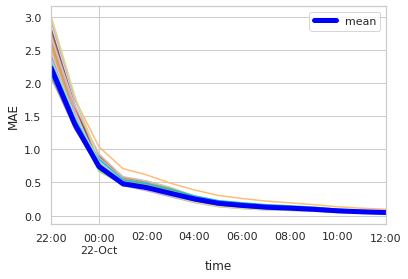

plotting


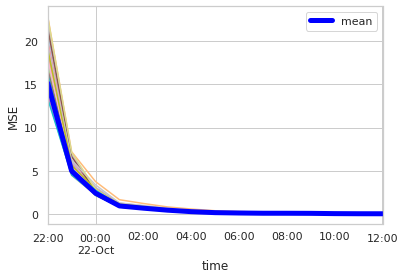

plotting


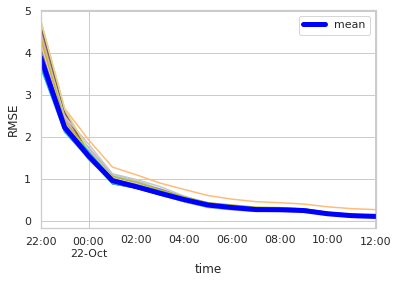

In [20]:
#  MAE, MSE, RMSE as function of time.
%autoreload
sns.set()
sns.set_style('whitegrid')
ensemble_tools.plot_ens_accuracy(dft2,'MAE')
plt.savefig(gdir + 'run{}_mae_ts_t{}{}.{}'.format(tag,threshold,pmtag,graphicstype))
plt.show()
ensemble_tools.plot_ens_accuracy(dft2,'MSE')
plt.savefig(gdir + 'run{}_mse_ts_t{}{}.{}'.format(tag,threshold,pmtag,graphicstype))
plt.show()
ensemble_tools.plot_ens_accuracy(dft2,'RMSE')
plt.savefig(gdir + 'run{}_rmse_ts_t{}{}.{}'.format(tag,threshold,pmtag,graphicstype))

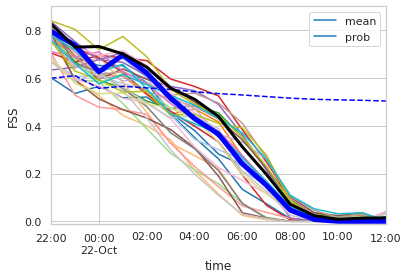

In [26]:
# FSS at one neightborhood size as a function of time.
# different colored lines are the different ensemble members.
# Uses output from the cell above.
%autoreload
sns.set()
sns.set_style('whitegrid')
# grid size is 0.1 degrees.
# neighborhood gives the number of grid squares to
# look at. 10 would be a 1degree x 1 degree area.
neighborhood = 3
ensemble_tools.plot_ens_fss_ts(dft,nval=neighborhood)
ax = plt.gca()
ax.set_ylim(-0.01,0.9)
plt.savefig(gdir + 'run{}_fss_ts_n{}_t{}{}.{}'.format(tag,neighborhood,threshold,pmtag,graphicstype))

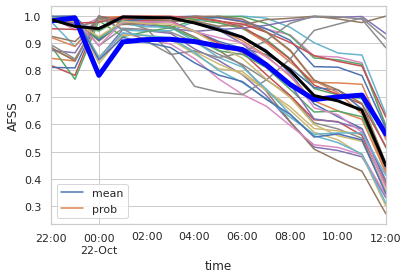

In [27]:
# plots the AFSS which is a measure of frequency bias as a function of time.
# The FSS will approach this value as neighborhood size approaches domain size.
# When pixel matching is used, this will always be 1.
%autoreload
afss = ensemble_tools.plot_afss_ts(dft)
# no reason to save if pixel matching is True.
if not pixel_match:
    plt.savefig(gdir + 'run{}_afss_ts_t{}.{}'.format(tag,threshold,graphicstype))
else:
    print('pixel match on')

# Look at one time period, different neighbhorhood sizes.

In [28]:
# Look at one time period, different neighbhorhood sizes.
%autoreload
tii=8
pixel_match=False
threshold=0.1
threshstr = str(threshold).replace('.','p')
timeval = aeval.cdump.time.values[tii]
print(timeval)
volcat,forecast = aeval.get_pair(tii)
print(aeval.concmult)
#forecast = aeval.cdump_hash[tii]
nb = np.arange(1,21,2)
nb = np.append(nb,[31,41,51])
if tii > 8:
    nb = np.append(nb,[61,71,81,91,101])
thresh=0.1
#nb = [11,81,91]
# msc and psc are CalcScores objects.
# msc is for the ensemble mean (deterinistic)
# psc is for the probabilistic model field.
msc, psc, df1, dfmae = ensemble_tools.ens_fss(forecast,volcat,threshold=threshold,
                                       neighborhoods=nb,
                                       return_objects=True,plot=False,
                                       pixel_match=pixel_match)
if pixel_match: pmtag='_pm'
else: pmtag = ''

2020-10-22T04:00:00.000000000
1


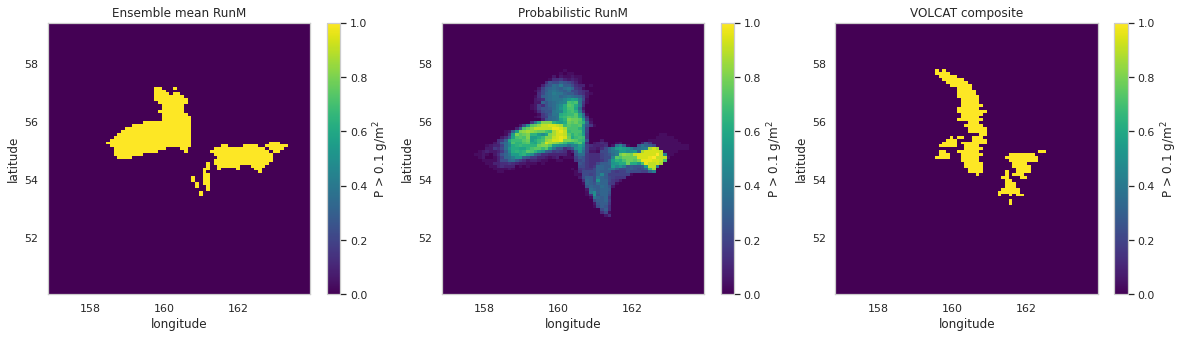

In [29]:
# Plots of 
fig = plt.figure(1,figsize=[20,5])
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
chash = {'label': 'P > {} g/m$^2$'.format(threshold)}
msc.binxra2.plot.pcolormesh(ax=ax1,x='longitude',y='latitude', cbar_kwargs=chash)
psc.binxra2.plot.pcolormesh(ax=ax2,x='longitude',y='latitude', cbar_kwargs=chash)
psc.binxra1.plot.pcolormesh(ax=ax3,x='longitude',y='latitude',cbar_kwargs=chash)
ax1.set_title('Ensemble mean Run{}'.format(tag))
ax2.set_title('Probabilistic Run{}'.format(tag))
ax3.set_title('VOLCAT composite')
timeval = pd.to_datetime(timeval)
timestr = timeval.strftime("%Y%m%dT%H")
timeval2 = timeval + datetime.timedelta(hours=1)
timestr2 = timeval2.strftime("T%H")
plt.savefig(gdir + 'binary_fields_run{}_t_{}_{}_{}{}'.format(tag,threshstr,timestr,timestr2,pmtag))

[0.54225352]


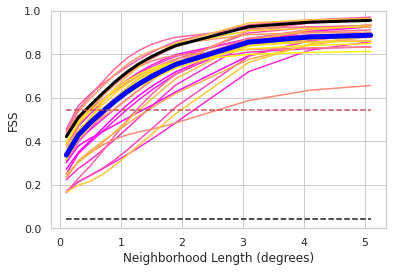

In [30]:
%autoreload
sns.set()
sns.set_style('whitegrid')
print(df1['uniform'].unique())
ensemble_tools.plot_ens_fss(df1,sizemult=0.1)
ax = plt.gca()
ax.set_ylim([0,1])
ax.set_ylabel('FSS')
#ax.set_xlim(1,5)
ax.set_xlabel('Neighborhood Length (degrees)')
plt.savefig(gdir + 'FSS_run{}_t{}_{}_{}'.format(tag, threshstr, timestr,timestr2))

In [31]:
df1[df1.ens=='mean']

Nlen       FBS   FBS_ref       FSS    random   uniform      afss   ens  \
1      1  0.072071  0.108631  0.336552  0.042254  0.542254  0.906006  mean   
3      3  0.048023  0.084169  0.429441  0.042254  0.542254  0.906006  mean   
5      5  0.036657  0.071497  0.487293  0.042254  0.542254  0.906006  mean   
7      7  0.028402  0.061416  0.537546  0.042254  0.542254  0.906006  mean   
9      9  0.022049  0.053162  0.585248  0.042254  0.542254  0.906006  mean   
11    11  0.017296  0.046516  0.628182  0.042254  0.542254  0.906006  mean   
13    13  0.013781  0.041181  0.665362  0.042254  0.542254  0.906006  mean   
15    15  0.011137  0.036849  0.697767  0.042254  0.542254  0.906006  mean   
17    17  0.009080  0.033262  0.727022  0.042254  0.542254  0.906006  mean   
19    19  0.007440  0.030235  0.753924  0.042254  0.542254  0.906006  mean   
31    31  0.002682  0.018680  0.856439  0.042254  0.542254  0.906006  mean   
41    41  0.001601  0.013330  0.879898  0.042254  0.542254  0.906006  mean   
51    51  0.001095  0.009767  0.887931  0.042254  0.542254  0.906006  mean   

                  time  length (degrees)  
1  2020-10-22 04:00:00               0.1  
3  2020-10-22 04:00:00               0.3  
5  2020-10-22 04:00:00               0.5  
7  2020-10-22 04:00:00               0.7  
9  2020-10-22 04:00:00               0.9  
11 2020-10-22 04:00:00               1.1  
13 2020-10-22 04:00:00               1.3  
15 2020-10-22 04:00:00               1.5  
17 2020-10-22 04:00:00               1.7  
19 2020-10-22 04:00:00               1.9  
31 2020-10-22 04:00:00               3.1  
41 2020-10-22 04:00:00               4.1  
51 2020-10-22 04:00:00               5.1

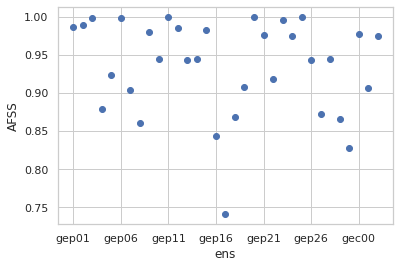

In [32]:
sns.set()
sns.set_style('whitegrid')
ensemble_tools.plot_afss(df1)
plt.savefig(gdir + 'AFSS_run{}_t{}_{}_{}'.format(tag, threshstr, timestr,timestr2))

/hysplit-users/alicec/anaconda3/envs/paris/lib/python3.8/site-packages/numpy/lib/function_base.py:4215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = asanyarray(y)
/hysplit-users/alicec/anaconda3/envs/paris/lib/python3.8/site-packages/numpy/lib/function_base.py:4219: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = asanyarray(x)
/hysplit-users/alicec/anaconda3/envs/paris/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples

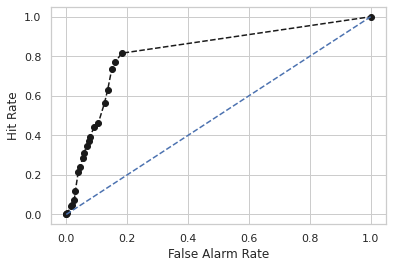

In [33]:
# Calculate ROC curve using 
%autoreload
xlist, ylist, area = psc.calc_roc(clip=True)
plume_stat.plot_roc(xlist,ylist)
threshstr = str(threshold).replace('.','p')
plt.savefig(gdir + 'ROC_run{}_t{}_{}_{}'.format(tag,threshstr, timestr,timestr2))

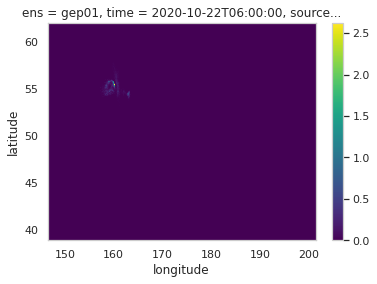

In [34]:
aeval.massload.sel(ens='gep01').isel(time=10).plot.pcolormesh(x='longitude',y='latitude')

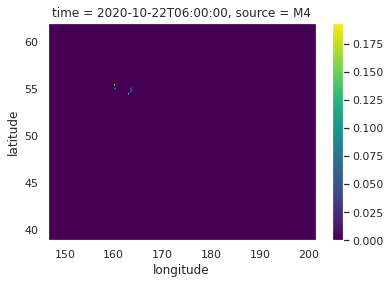

In [66]:
# Ensemble frequency of exceedance
# set a threshold.
# count how many ensemble members in a pixel exceed that threshold.
# divide by total number of ensemble members.
# ensemble frequency of exceedance.
# could be probability of exceedance.

%autoreload
sns.set()
temp = aeval.massload
atl = ensemble_tools.ATL(temp,thresh=2)
atl.isel(time=10).plot.pcolormesh(x='longitude',y='latitude')

# Visual comparison

2020-10-22T04:00:00.000000000
gep26
tii 8


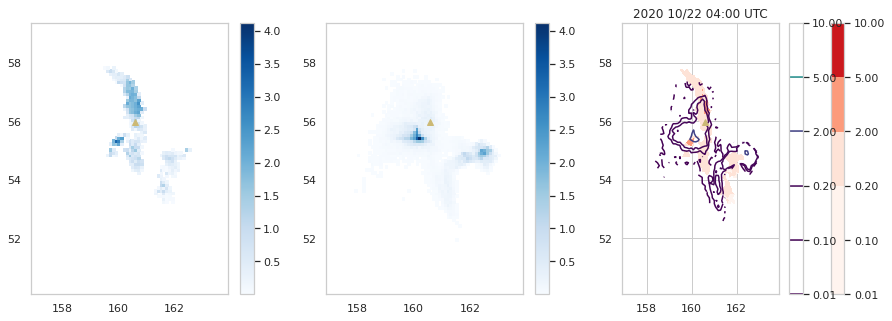

gep05
tii 8


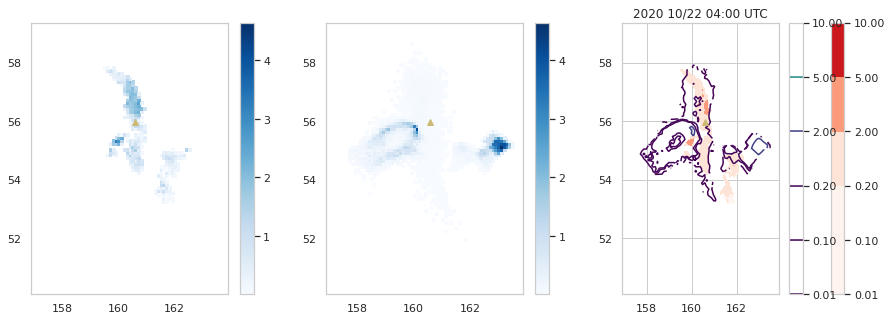

gep10
tii 8


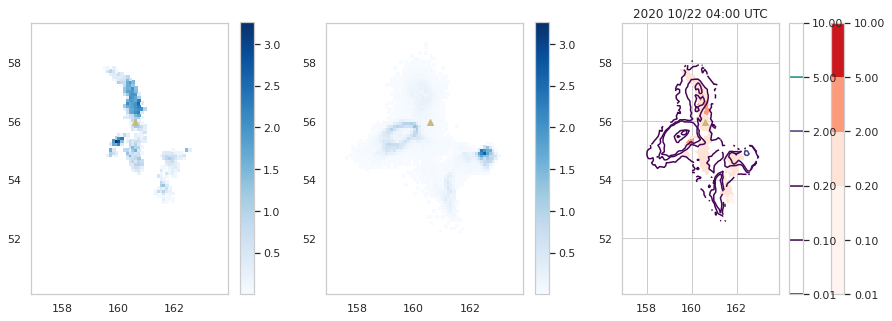

gec00
tii 8


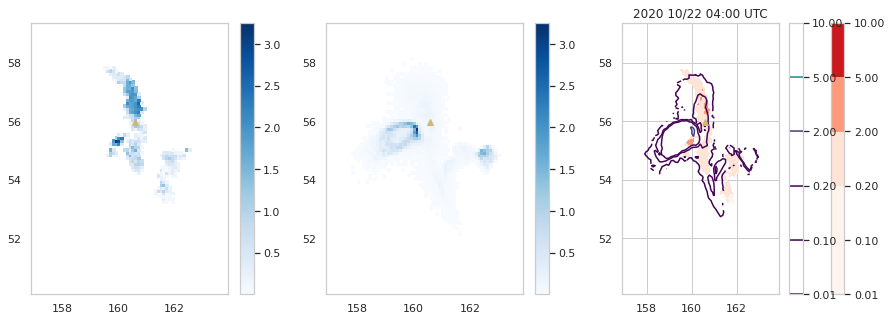

tii 8


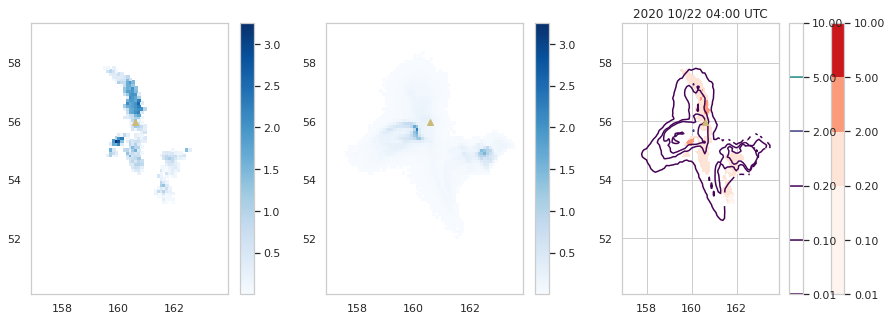

tii 8


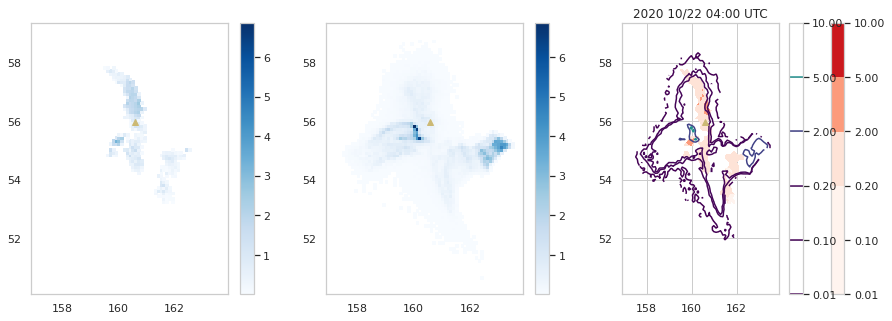

In [37]:
%autoreload
tii = 8  # time period
print(aeval.massload.time.values[tii])
# Comparison of some of the different ensemble members
for ens in ['gep26','gep05','gep10','gec00']:
    print(ens)
    fig = aeval.compare_forecast(aeval.massload.sel(ens=ens).isel(time=tii),vloc=vloc)

    plt.savefig(gdir + 'pcolormesh_run{}_t{}_{}_{}_{}.png'.format(tag,threshstr, timestr,timestr2,ens))
    plt.show()
#plt.show()
#fig = aeval.compare_forecast(aeval.massload.sel(ens='gep05').isel(time=tii),vloc=vloc)
#plt.show()
#fig = aeval.compare_forecast(aeval.massload.sel(ens='gep10').isel(time=tii),vloc=vloc)
#plt.show()
#fig = aeval.compare_forecast(aeval.massload.sel(ens='gep15').isel(time=tii),vloc=vloc)
#plt.show()
#fig = aeval.compare_forecast(aeval.massload.sel(ens='gec00').isel(time=tii),vloc=vloc)
#plt.show()
# mean of ensemble
fig = aeval.compare_forecast(aeval.massload.mean(dim='ens').isel(time=tii),vloc=vloc)
plt.savefig(gdir + 'pcolormesh_run{}_t{}_{}_{}_ensmean.png'.format(tag,threshstr, timestr,timestr2))
plt.show()
# maximum of ensemble
fig = aeval.compare_forecast(aeval.massload.max(dim='ens').isel(time=tii),vloc=vloc)
plt.savefig(gdir + 'pcolormesh_run{}_t{}_{}_{}_ensmax.png'.format(tag,threshstr, timestr,timestr2))

# Comparing CDF

['2020-10-21T20:00:00.000000000' '2020-10-21T21:00:00.000000000'
 '2020-10-21T22:00:00.000000000' '2020-10-21T23:00:00.000000000'
 '2020-10-22T00:00:00.000000000' '2020-10-22T01:00:00.000000000'
 '2020-10-22T02:00:00.000000000' '2020-10-22T03:00:00.000000000'
 '2020-10-22T04:00:00.000000000' '2020-10-22T05:00:00.000000000'
 '2020-10-22T06:00:00.000000000' '2020-10-22T07:00:00.000000000'
 '2020-10-22T08:00:00.000000000' '2020-10-22T09:00:00.000000000'
 '2020-10-22T10:00:00.000000000' '2020-10-22T11:00:00.000000000'
 '2020-10-22T12:00:00.000000000' '2020-10-22T13:00:00.000000000'
 '2020-10-22T14:00:00.000000000' '2020-10-22T15:00:00.000000000'
 '2020-10-22T16:00:00.000000000' '2020-10-22T17:00:00.000000000'
 '2020-10-22T18:00:00.000000000' '2020-10-22T19:00:00.000000000'
 '2020-10-22T20:00:00.000000000' '2020-10-22T21:00:00.000000000'
 '2020-10-22T22:00:00.000000000' '2020-10-22T23:00:00.000000000'
 '2020-10-23T00:00:00.000000000' '2020-10-23T01:00:00.000000000'
 '2020-10-23T02:00:00.000

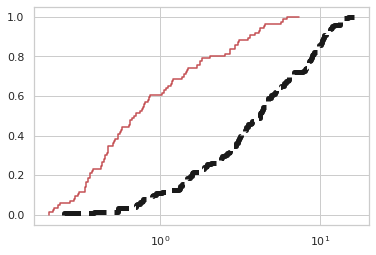

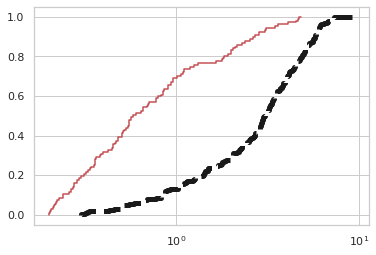

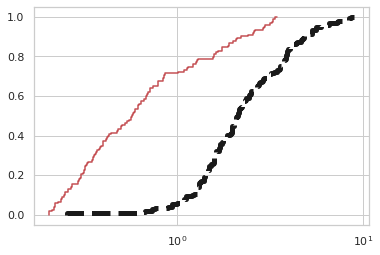

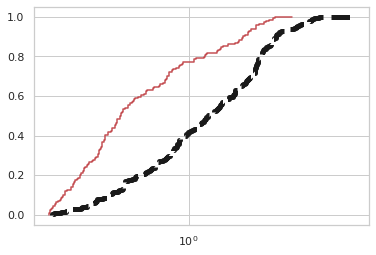

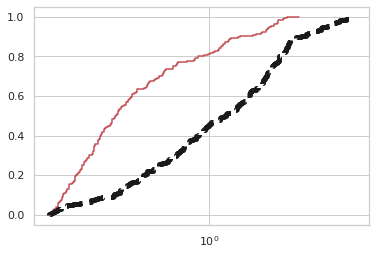

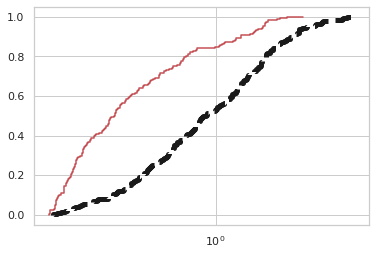

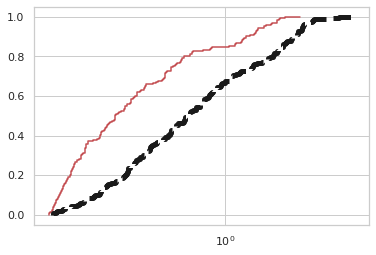

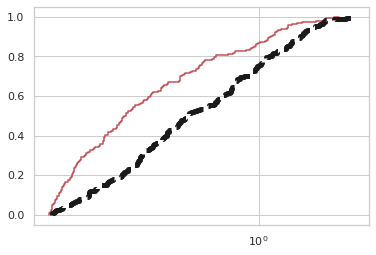

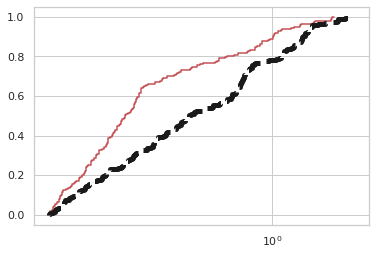

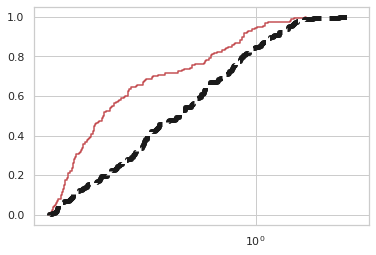

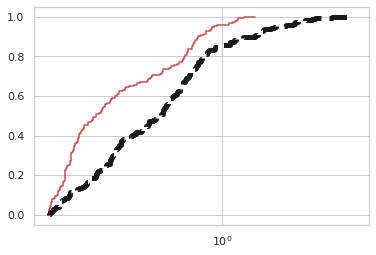

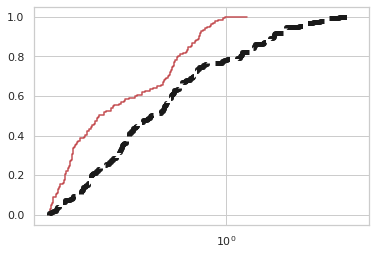

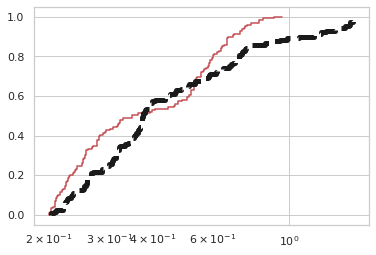

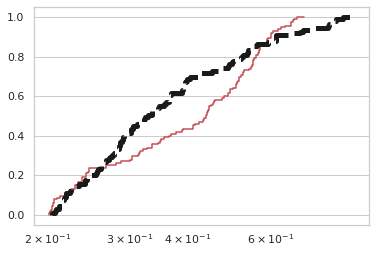

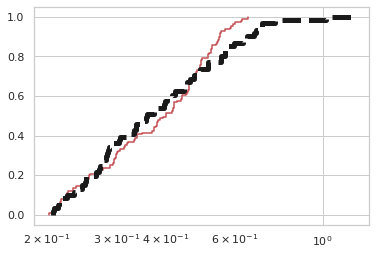

<Figure size 432x288 with 0 Axes>

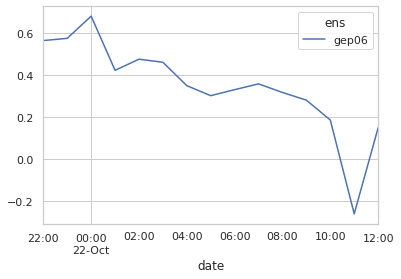

In [38]:
%autoreload
# one ensemble member at all times.
tii=5
timelist = aeval.massload.time.values
enslist = aeval.massload.ens.values
enslist = [enslist[tii]]
#timelist = [aeval.massload.time.values[tii]]
print(timelist)
#print(enslist)
threshold = 0.2
# CDF with pixel matching. Threshold will be different for every ensemble member as well as fo
# volcat data. First threshold is applied to VOLCAT data. Number of VOLCAT pixels above threshold
# is counted.
use_pixel_match=False
aeval.mass_cdf_plot(timelist,enslist,threshold=threshold,use_pixel_match=use_pixel_match)
ax = plt.gca()
#add_lines(ax)
plt.show()
#use_pixel_match=False
#kslist = aeval.mass_cdf_plot(timelist,enslist,threshold=threshold,use_pixel_match=use_pixel_match)
#ax = plt.gca()
#add_lines(ax)

In [39]:
#SET THE TIME
d1 = datetime.datetime(2020,10,22,4)
timestr = d1.strftime("%Y%m%dT%H")

[datetime.datetime(2020, 10, 22, 4, 0)]
saving pixel_match_cdf_M_20201022T04


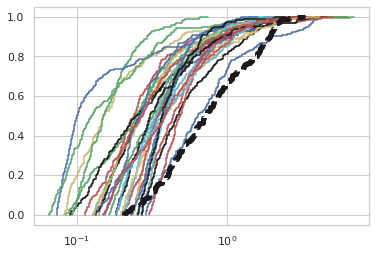

<Figure size 432x288 with 0 Axes>

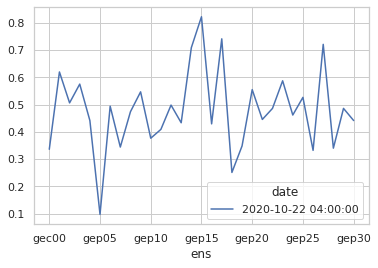

saving cdf_M_20201022T04


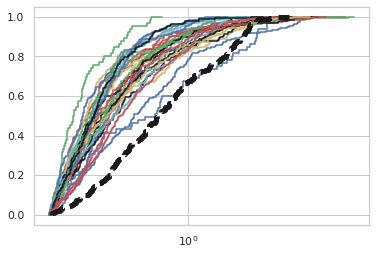

<Figure size 432x288 with 0 Axes>

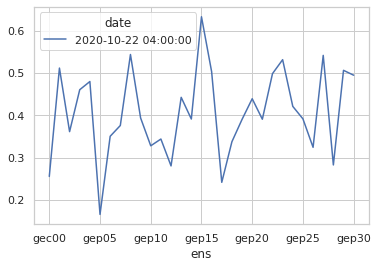

In [40]:
%autoreload
# CDF for all ensemble members at one time.
enslist = aeval.massload.ens.values
enslist = None
timelist=[d1]
print(timelist)
#print(enslist)l.
threshold = 0.2
# CDF with pixel matching. Threshold will be different for every ensemble member as well as fo
# volcat data. First threshold is applied to VOLCAT data. Number of VOLCAT pixels above threshold
# is counted.
use_pixel_match=True
figname = 'pixel_match_cdf_{}_{}'.format(tag,timestr)
aeval.mass_cdf_plot(timelist,enslist,threshold=threshold,use_pixel_match=use_pixel_match,figname=figname)
ax = plt.gca()
plt.savefig(gdir + 'pixel_match_ks_{}_{}'.format(tag,timestr))
#add_lines(ax)
plt.show()
# CDF with no pixel matching. Thresholds are the same for every ensemble member and volcat data.
# number of above threshold pixels will be different.
use_pixel_match=False
figname = 'cdf_{}_{}'.format(tag,timestr)
kslist = aeval.mass_cdf_plot(timelist,enslist,threshold=threshold,use_pixel_match=use_pixel_match,figname=figname)
ax = plt.gca()
plt.savefig(gdir + 'ks_{}_{}'.format(tag,timestr))
#add_lines(ax)


# ROC diagrams

In [54]:
%autoreload
tii = 8
volcat = aeval.volcat_avg_hash[tii]
forecast = aeval.cdump_hash[tii]
probscores = plume_stat.CalcScores(volcat, forecast,threshold=0.1,probabilistic=True)


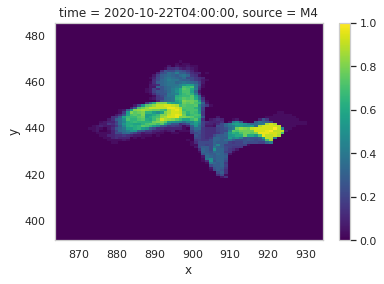

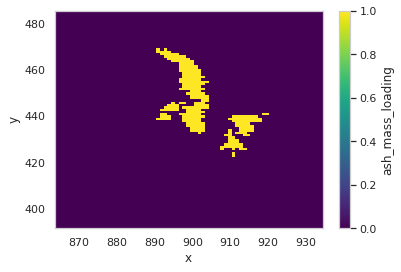

In [55]:
probscores.binxra2.plot.pcolormesh()
plt.show()
probscores.binxra1.plot.pcolormesh()

/hysplit-users/alicec/anaconda3/envs/paris/lib/python3.8/site-packages/numpy/lib/function_base.py:4215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = asanyarray(y)
/hysplit-users/alicec/anaconda3/envs/paris/lib/python3.8/site-packages/numpy/lib/function_base.py:4219: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = asanyarray(x)
/hysplit-users/alicec/anaconda3/envs/paris/lib/python3.8/site-packages/numpy/lib/function_base.py:4215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tu

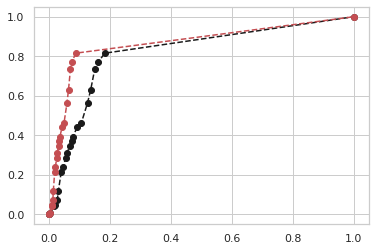

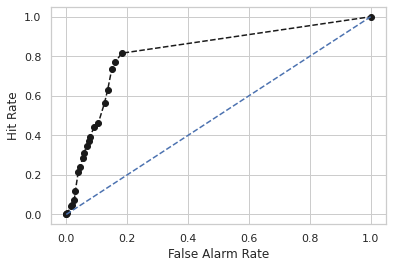

In [56]:
%autoreload
sns.set()
sns.set_style('whitegrid')
pm=True
datedf1 = pd.to_datetime(aeval.cdump.time.values[tii])
timetag = datedf1.strftime("%Y%m%dT%H")
if pm: timetag + '_pm'

xlist, ylist, area = probscores.calc_roc(clip=True)
xlist2,ylist2, area = probscores.calc_roc(clip=False)
plt.plot(xlist,ylist,'--ko')
plt.plot(xlist2,ylist2,'--ro')
plt.show()
plume_stat.plot_roc(xlist,ylist)
plt.savefig(gdir + 'ROC_run{}_{}'.format(tag,timetag))
#plume_stat.plot_roc(xlist2,ylist2)

# Reliability Curves

In [45]:
from utilhysplit.evaluation import reliability


In [46]:
tii = 8
volcat = aeval.volcat_avg_hash[tii]
forecast = aeval.cdump_hash[tii]

In [47]:
print(aeval.cdump.time.values[16])

2020-10-22T12:00:00.000000000


In [48]:
str.join('.',map(str,[1,2]))

'1.2'

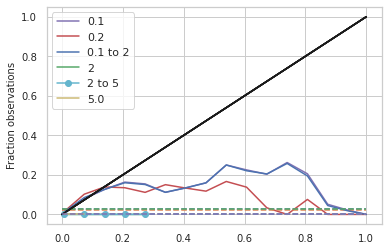

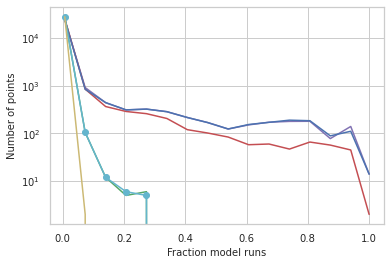

In [63]:
%autoreload
num=15  #number of bins to use on x axis.
# 
threshlist = [0.1,0.2,[0.1,2],2,[2,5],5.0]
clrs = ['-m','-r','-b','-g','-co','-y']
rclist = []
labels = []
fig = plt.figure(1)
ax = fig.add_subplot(1,1,1)
fig2 = plt.figure(2)
ax2 = fig2.add_subplot(1,1,1)
for thresh in threshlist:
    if isinstance(thresh,(float,int)):
        labels.append(str(thresh))
    else:
        labels.append('{} to {}'.format(thresh[0],thresh[1]))
    rclist.append(reliability.ReliabilityCurve(thresh,num))
# time periods to include in reliability diagram.
tlist = [2,3,4,5,6,7,8]
tlist = [9,10,11]
for tii in tlist:
#for tii in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]:
    volcat = aeval.volcat_avg_hash[tii]
    forecast = aeval.cdump_hash[tii]
    for jjj, rc in enumerate(rclist):
        dfin = rc.reliability_add_xra(volcat,forecast,fill=True)

for jjj, rc in enumerate(rclist):
    reliability.sub_reliability_plot(rc,ax,clr=clrs[jjj],fs=10,label=labels[jjj])
    reliability.sub_reliability_number_plot(rc,ax2,clr=clrs[jjj],fs=10,label=labels[jjj])

rel_time_str = str.join('_',map(str,tlist))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,labels,loc='upper left')

fig.savefig(gdir + 'reliability_{}_t{}'.format(tag,rel_time_str))
fig2.savefig(gdir + 'reliability_number_{}_t{}'.format(tag,rel_time_str))

0.2


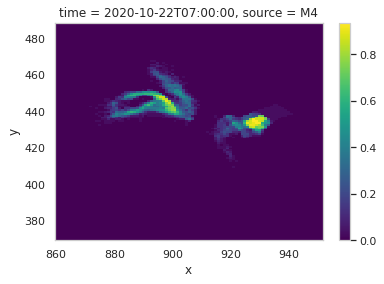

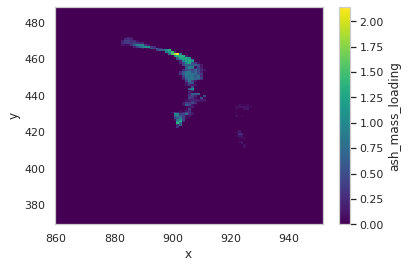

In [64]:
thresh=0.2
print(thresh)
prob = ensemble_tools.ATL(forecast,thresh=thresh,norm=True)
prob.plot.pcolormesh()
plt.show()
volcat.plot.pcolormesh()

ROW ens
gec00    0.000000
gep27    0.000000
gep14    0.000000
obs      0.000000
gep01    0.000000
gep02    0.000000
gep03    0.000005
gep15    0.000819
gep20    0.001004
gep25    0.001453
gep23    0.001816
gep09    0.002409
gep11    0.002410
gep12    0.003311
gep05    0.004061
gep22    0.004213
gep21    0.006537
gep10    0.010794
gep17    0.011269
gep13    0.011777
gep06    0.016827
gep29    0.020593
gep26    0.028155
gep19    0.029261
gep18    0.030430
gep07    0.031115
gep16    0.040256
gep24    0.048762
gep28    0.056410
gep08    0.084696
gep04    0.086820
gep30    0.199839
Name: 888_453, dtype: float64
Rank 3 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep02    0.000000
gep27    0.000000
gep14    0.000000
gep03    0.000005
gep20    0.001008
gep25    0.001137
gep23    0.001215
gep12    0.002217
gep09    0.002418
gep11    0.002419
gep15    0.002879
gep22    0.003178
gep05    0.004073
gep21    0.009872
gec00    0.013442
gep13    0.016454
gep06    0.017747
gep10    0.021639
gep17  

Rank 0 0.0
ROW ens
obs      0.000000
gep14    0.005882
gep03    0.008703
gep27    0.012349
gep20    0.014922
gep02    0.020715
gep11    0.033921
gep25    0.034950
gep01    0.052995
gep12    0.080237
gep21    0.121518
gep15    0.129316
gep09    0.143160
gep05    0.158920
gep23    0.165438
gep22    0.216936
gep26    0.243964
gep13    0.301640
gec00    0.328208
gep17    0.342158
gep06    0.366737
gep10    0.557066
gep24    0.657116
gep29    1.030665
gep28    1.237681
gep19    1.267094
gep18    1.347195
gep16    1.404902
gep08    1.496804
gep07    1.768130
gep30    1.959931
gep04    2.515604
Name: 892_454, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep27    0.002994
gep14    0.003103
gep20    0.007126
gep03    0.015669
gep02    0.016662
gep11    0.023942
gep26    0.077766
gep21    0.082298
gep25    0.115967
gep15    0.122060
gep06    0.162767
gep13    0.164367
gep01    0.169897
gep12    0.203140
gep09    0.328257
gep22    0.330669
gep23    0.333282
gec00    0.363120
gep05    0.406

Rank 31 4.580052852630615
ROW ens
obs      0.000000
gep04    0.000000
gep26    0.000000
gep11    0.000000
gep14    0.001556
gep20    0.002359
gep27    0.002415
gep02    0.005089
gep03    0.006942
gep21    0.008196
gec00    0.008715
gep24    0.012585
gep15    0.018988
gep06    0.020267
gep13    0.026347
gep25    0.027519
gep01    0.036024
gep12    0.048656
gep08    0.048987
gep19    0.054626
gep22    0.087631
gep09    0.092741
gep29    0.092889
gep10    0.097719
gep17    0.098996
gep18    0.101496
gep23    0.102287
gep05    0.102552
gep07    0.114237
gep28    0.211007
gep16    0.274581
gep30    0.509945
Name: 895_457, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep02    0.000000
gep26    0.000000
gep04    0.000000
gep24    0.000000
gep20    0.000000
gep11    0.000000
gep27    0.000175
gep14    0.000313
gep15    0.002628
gep13    0.002805
gep21    0.003942
gec00    0.004301
gep19    0.004348
gep06    0.005272
gep03    0.006093
gep12    0.009812
gep01    0.013135
gep25    0.014308

Rank 31 10.489873886108398
ROW ens
gep06    0.053928
gep23    0.072242
gep09    0.089945
gep12    0.107325
gep28    0.120576
gep03    0.137627
gep17    0.143992
gep30    0.171847
gep25    0.220621
gep05    0.244456
gep22    0.259558
gep08    0.317529
gep11    0.346118
gep16    0.376309
gep15    0.389712
gep14    0.566524
gep21    0.670401
gep10    0.732402
gep01    0.800297
gec00    0.874339
gep20    0.928762
gep29    1.125696
gep27    1.314902
gep24    1.605796
gep02    1.637447
gep07    1.638264
gep18    1.647908
gep04    1.670008
gep26    1.821524
gep19    2.464024
gep13    2.498542
obs      5.947607
Name: 898_453, dtype: float64
Rank 31 5.947606563568115
ROW ens
gep03    0.011394
gep25    0.012596
gep06    0.017143
gep28    0.022191
gep14    0.022903
gep21    0.035622
gep09    0.039034
gep22    0.039636
gep11    0.044308
gep29    0.048677
gep20    0.054781
gep01    0.055623
gep08    0.055660
gep27    0.060602
gep17    0.060781
gep15    0.068995
gep23    0.069195
gep05    0.080442
g

Rank 23 0.7761324048042297
ROW ens
gep15    0.000000
gep01    0.000000
gep21    0.004079
gep12    0.004184
gep03    0.004315
gep05    0.029070
gep25    0.029912
gep28    0.030513
gep27    0.129396
gep20    0.207077
gep11    0.212251
gep17    0.213137
gep14    0.288132
gep09    0.339226
gec00    0.387464
gep30    0.462443
gep02    0.482541
gep16    0.544481
gep22    0.582112
gep08    0.647248
gep06    0.685555
gep13    0.738828
gep07    0.881463
gep24    1.043126
gep19    1.054321
gep23    1.109482
gep26    1.188540
gep18    1.267647
gep10    1.276404
gep04    1.563231
gep29    2.523028
obs      4.009475
Name: 902_447, dtype: float64
Rank 31 4.009475231170654
ROW ens
gep01    0.000000
gep03    0.000000
gep15    0.002260
gep12    0.031089
gep21    0.033065
gep17    0.125174
gep02    0.146574
gep05    0.149200
gep27    0.166096
gep25    0.192630
gep28    0.200867
gep14    0.237261
gep24    0.274449
gep06    0.275930
gep10    0.393796
gep20    0.529742
gep09    0.572998
gep23    0.601109
g

Rank 30 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep01    0.000000
gep30    0.000000
obs      0.000000
gep05    3.997978
Name: 911_448, dtype: float64
Rank 30 0.0
ROW ens
obs      0.000000e+00
gep01    0.000000e+00
gep02    0.000000e+00
gep27    0.000000e+00
gep05    0.000000e+00
gep14    0.000000e+00
gep11    0.000000e+00
gep03    7.523642e-07
gep25    2.115724e-04
gep06    3.962785e-04
gep15    5.472237e-04
gep23    6.087206e-04
gep20    1.005994e-03
gep22    1.054808e-03
gep12    1.109714e-03
gep09    2.012931e-03
ge

ROW ens
obs      0.000000
gep02    0.000000
gep14    0.000000
gep20    0.001415
gep27    0.001812
gep03    0.002871
gep05    0.008171
gep01    0.009813
gep25    0.011454
gep15    0.018782
gep12    0.023123
gep09    0.023732
gep11    0.030023
gep22    0.035035
gep23    0.035463
gep21    0.042951
gep06    0.065499
gep13    0.082137
gec00    0.085604
gep17    0.107785
gep10    0.115345
gep26    0.117099
gep24    0.175073
gep29    0.360958
gep28    0.373418
gep18    0.406482
gep19    0.423775
gep08    0.467008
gep30    0.510605
gep04    0.593200
gep16    0.609036
gep07    0.647572
Name: 889_455, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep14    0.000000
gep03    0.000914
gep20    0.001215
gep27    0.002673
gep02    0.005126
gep01    0.008202
gep25    0.013609
gep11    0.015819
gep26    0.021301
gep23    0.024980
gep15    0.025071
gep21    0.026237
gep12    0.031801
gep05    0.032716
gep09    0.033873
gep22    0.053238
gep06    0.068617
gep13    0.104239
gep17    0.146037
gec00  

ROW ens
obs      0.000000
gep27    0.012402
gep14    0.022129
gep20    0.046384
gep17    0.053319
gep03    0.064633
gep15    0.069885
gep19    0.072330
gep01    0.085558
gep09    0.093082
gep10    0.112577
gep12    0.153760
gep23    0.179091
gep22    0.215765
gep11    0.217648
gep25    0.246860
gep05    0.267616
gep16    0.277478
gep13    0.282410
gep02    0.288542
gep07    0.426840
gep21    0.678402
gep29    0.691375
gep24    0.846990
gec00    0.862939
gep06    1.064053
gep04    1.075067
gep26    1.458165
gep28    1.886181
gep08    2.462730
gep18    2.924690
gep30    3.275950
Name: 892_450, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep14    0.015521
gep27    0.023806
gep20    0.025103
gep03    0.031058
gep01    0.042271
gep09    0.051148
gep15    0.056223
gep17    0.060357
gep12    0.065995
gep25    0.083752
gep10    0.105615
gep02    0.110694
gep23    0.115248
gep22    0.143301
gep05    0.144353
gep11    0.210731
gep13    0.226534
gec00    0.256886
gep19    0.257348
gep21  

ROW ens
obs      0.000000
gep26    0.000000
gep11    0.001063
gep14    0.001246
gep03    0.002592
gep24    0.003016
gep20    0.003704
gep27    0.005379
gep02    0.016147
gep04    0.019853
gep21    0.020349
gep06    0.025062
gep13    0.027134
gec00    0.033767
gep15    0.054153
gep25    0.064019
gep01    0.099742
gep19    0.118632
gep12    0.122637
gep08    0.123345
gep18    0.174965
gep09    0.181983
gep17    0.184742
gep22    0.197106
gep29    0.220459
gep07    0.226846
gep23    0.241503
gep05    0.261075
gep10    0.269668
gep28    0.378089
gep16    0.534836
gep30    0.870284
Name: 894_459, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep02    0.000000
gep04    0.000000
gep26    0.000000
gep24    0.000000
gep11    0.000000
gep14    0.001252
gep27    0.002263
gep20    0.002286
gep03    0.002601
gep13    0.007360
gep06    0.009537
gep21    0.010380
gep15    0.011442
gep19    0.011562
gec00    0.012187
gep12    0.033123
gep25    0.037824
gep01    0.039234
gep08    0.052652
gep17  

Rank 31 2.87225604057312
ROW ens
gep28    0.000000
gep25    0.000000
gep11    0.000000
gep12    0.000000
gep01    0.001589
gep05    0.003348
gep27    0.006133
gep21    0.006487
gep02    0.012153
gep20    0.015012
gec00    0.016242
gep19    0.016386
gep13    0.022029
gep03    0.024528
gep14    0.024893
gep15    0.030475
gep09    0.031937
gep24    0.033020
gep22    0.037083
gep17    0.049789
gep30    0.053623
gep04    0.054276
gep26    0.055484
gep10    0.057547
gep07    0.063284
gep06    0.065576
gep23    0.083014
gep29    0.086097
gep18    0.107991
gep08    0.111302
gep16    0.126644
obs      2.701042
Name: 897_443, dtype: float64
Rank 31 2.7010421752929688
ROW ens
gep25    0.000000
gep05    0.001680
gep12    0.004763
gep01    0.004784
gep11    0.006165
gep28    0.007448
gep21    0.009821
gep20    0.018955
gep19    0.021292
gep27    0.023615
gec00    0.025098
gep14    0.029577
gep09    0.030237
gep03    0.030718
gep02    0.035952
gep13    0.038406
gep17    0.046199
gep15    0.052014
ge

Rank 31 6.983121871948242
ROW ens
gep24    0.023963
gep12    0.038915
gep09    0.041985
gep07    0.043141
gep23    0.083623
gep20    0.107845
gep05    0.130992
gep06    0.178528
gep04    0.179234
gep19    0.207167
gep10    0.211409
gep17    0.218560
gep25    0.222423
gec00    0.225579
gep02    0.272819
gep27    0.293226
gep14    0.299284
gep01    0.318841
gep29    0.412813
gep21    0.451848
gep18    0.517188
gep30    0.531437
gep08    0.639039
gep13    0.648572
gep03    0.768500
gep16    0.781868
gep28    0.802860
gep26    0.804345
gep15    0.810684
gep11    0.849488
gep22    0.999584
obs      7.195391
Name: 899_449, dtype: float64
Rank 31 7.1953911781311035
ROW ens
gep09    0.126624
gep20    0.242283
gep17    0.290912
gep27    0.389385
gep05    0.458429
gep06    0.546298
gep08    0.566049
gec00    0.639148
gep14    0.644942
gep25    0.723098
gep29    0.729226
gep22    0.753000
gep30    0.805620
gep12    0.889070
gep01    0.962984
gep03    1.069533
gep02    1.090375
gep21    1.176826
g

Rank 31 3.0226104259490967
ROW ens
gec00    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep29    0.000000
gep16    0.000000
gep30    0.000000
gep27    0.000000
gep14    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep05    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep01    0.000000
gep13    0.000000
gep28    0.000000
gep15    0.001138
gep17    0.003072
obs      0.858639
Name: 901_457, dtype: float64
Rank 31 0.8586389422416687
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000


ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
gep15    0.000000
obs      0.000000
gep01    0.000000
gep08    0.000000
gep03    0.000000
gep12    0.000000
gep05    0.000000
gep09    0.004848
gep29    0.040807
gep14    0.151132
gep22    0.172888
gep10    0.192900
gep07    0.266236
gep02    0.396769
gep23    0.678170
gep17    0.725277
gep06    0.777509
gep24    0.927334
gep11    0.951599
gep04    1.109450
Name: 905_444, dtype: float64
Rank 13 0.0
ROW ens
gep15    0.000000
gep01    0.000000
gep27    0.000000
gep03    0.000000
gep21    0.001845
gep12    0.002776
gec00    0.006222
gep05    0.009642
gep16    0.010133
gep25    0.010631
gep28    0.010845
gep30    0.017010
gep20    0.025543
gep19    0.028408
gep08    0.031744
gep09    0.037607
gep26    0.040676
gep13    0.069120
gep29    0.069144
gep18    0.114632
gep14 

Rank 30 0.4956144094467163
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep01    0.000000
gep30    0.000000
obs      0.000000
gep05    2.680035
Name: 913_446, dtype: float64
Rank 30 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.0000

Rank 0 0.0
ROW ens
obs      0.000000
gep14    0.000000
gep03    0.000005
gep01    0.000749
gep27    0.001216
gep20    0.001466
gep09    0.002800
gep25    0.003246
gec00    0.003399
gep02    0.003403
gep05    0.003682
gep15    0.004988
gep23    0.005577
gep12    0.007694
gep13    0.009515
gep22    0.009977
gep17    0.013549
gep10    0.015432
gep11    0.016624
gep21    0.025578
gep06    0.043419
gep24    0.059226
gep29    0.060350
gep19    0.068143
gep26    0.068742
gep07    0.082197
gep08    0.096042
gep28    0.102638
gep16    0.103651
gep18    0.109234
gep04    0.155533
gep30    0.165756
Name: 887_452, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep14    0.000000
gep03    0.000437
gep01    0.000686
gep25    0.000884
gep20    0.002197
gep02    0.002635
gep27    0.002726
gep23    0.003024
gep09    0.003614
gep22    0.004213
gep05    0.006321
gep15    0.008343
gep11    0.008438
gep12    0.009341
gep17    0.015841
gec00    0.017496
gep10    0.017744
gep21    0.019622
gep13    0.021

Rank 0 0.0
ROW ens
obs      0.000000
gep14    0.000000
gep03    0.000030
gep20    0.002022
gep25    0.002725
gep01    0.003282
gep27    0.006485
gep11    0.008360
gep12    0.013198
gep23    0.013258
gep09    0.018075
gep05    0.027199
gep02    0.031849
gep15    0.034213
gep21    0.035442
gep22    0.039350
gep26    0.067717
gep17    0.088712
gec00    0.093863
gep06    0.099302
gep10    0.135546
gep13    0.176209
gep24    0.211840
gep29    0.243421
gep08    0.285228
gep18    0.327491
gep16    0.379918
gep28    0.403541
gep19    0.433067
gep30    0.486525
gep07    0.609095
gep04    0.798243
Name: 889_456, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep14    0.000000
gep03    0.001149
gep01    0.001637
gep20    0.002643
gep25    0.003936
gep27    0.008572
gep23    0.012205
gep12    0.014785
gep02    0.016745
gep11    0.019087
gep22    0.019155
gep26    0.021272
gep21    0.024953
gep09    0.034018
gep15    0.034344
gep05    0.036597
gep06    0.099225
gep13    0.099998
gep17    0.111

ROW ens
obs      0.000000
gep27    0.000000
gep02    0.000000
gep20    0.000000
gep14    0.000000
gep03    0.000005
gep11    0.001221
gep26    0.007139
gep21    0.008395
gep15    0.009099
gep13    0.012661
gep06    0.013860
gep25    0.020702
gep12    0.032540
gep01    0.032634
gep08    0.036203
gec00    0.041607
gep24    0.045878
gep22    0.048354
gep09    0.059313
gep17    0.076226
gep19    0.078597
gep23    0.081103
gep05    0.105834
gep18    0.107449
gep10    0.108064
gep29    0.166401
gep28    0.187646
gep04    0.213914
gep16    0.255789
gep07    0.292839
gep30    0.355504
Name: 891_461, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000e+00
gep27    0.000000e+00
gep02    0.000000e+00
gep26    0.000000e+00
gep19    0.000000e+00
gep14    0.000000e+00
gep11    0.000000e+00
gep03    7.593261e-07
gep20    2.032445e-04
gep13    9.004012e-04
gep06    2.289696e-03
gep24    3.023782e-03
gep15    3.342598e-03
gep21    3.445627e-03
gep08    4.537610e-03
gec00    6.817990e-03
gep25    7.1273

ROW ens
gep24    0.006953
gep19    0.007654
gep12    0.013541
gep11    0.015485
gep02    0.016024
gep13    0.024125
gep04    0.025282
gep07    0.048262
gep30    0.048528
gep20    0.069228
gep14    0.073685
gep23    0.087962
gep03    0.089797
gep28    0.109951
gep29    0.113266
gep18    0.117553
gep10    0.125300
gep08    0.126707
gep06    0.137895
gep16    0.146062
gec00    0.147667
gep09    0.158745
gep26    0.163442
gep27    0.186339
gep17    0.191106
gep22    0.191794
gep15    0.210167
gep25    0.293420
gep01    0.676524
gep21    0.733751
gep05    1.663346
obs      4.676112
Name: 894_445, dtype: float64
Rank 31 4.676112174987793
ROW ens
gep19    0.019893
gep13    0.025389
gep24    0.029385
gep04    0.058424
gep11    0.061458
gep12    0.143232
gep02    0.151227
gep27    0.158910
gep07    0.197268
gep17    0.200061
gep18    0.266749
gep26    0.275248
gep14    0.275436
gep16    0.288612
gep30    0.289255
gep15    0.318899
gep03    0.436615
gep28    0.463807
gep01    0.477119
gep23    0

Rank 30 1.7355009317398071
ROW ens
gep14     0.061943
gep17     0.073817
gep27     0.120174
gep09     0.151178
gep15     0.214777
gep03     0.230887
gep01     0.276995
gep21     0.451521
gep20     0.508238
gep25     0.581073
gep08     0.687636
gep22     0.701805
gep30     0.925611
gep12     1.059569
gep06     1.139502
gep10     1.216213
gep29     1.352884
obs       1.479310
gep07     1.581108
gep05     1.759810
gep02     1.878542
gec00     1.978374
gep11     2.186418
gep23     2.186678
gep18     3.039464
gep28     3.130992
gep19     3.341609
gep16     3.812996
gep26     4.230084
gep04     6.032518
gep24    12.115879
gep13    13.946963
Name: 896_449, dtype: float64
Rank 17 1.4793096780776978
ROW ens
gep17    0.073903
gep14    0.090982
gep27    0.200085
gep15    0.236465
gep05    0.268057
gep03    0.269251
gep21    0.273174
gep01    0.287947
gep09    0.294774
gep06    0.323079
gep20    0.633114
gep22    0.660457
gep02    0.678561
gep30    0.729568
gec00    0.881827
gep25    0.901739
gep0

Rank 31 2.3350043296813965
ROW ens
obs      0.000000
gep24    0.030397
gep07    0.058317
gep09    0.058652
gep12    0.083503
gep20    0.105177
gep23    0.111403
gep06    0.118630
gep25    0.118978
gep05    0.120418
gep17    0.134397
gep02    0.159973
gep27    0.197857
gep10    0.217303
gep04    0.226739
gep19    0.229549
gep14    0.262779
gec00    0.273297
gep01    0.337142
gep30    0.416562
gep21    0.455696
gep03    0.456878
gep29    0.497356
gep15    0.506760
gep08    0.540177
gep22    0.577048
gep16    0.640420
gep18    0.668593
gep11    0.706110
gep13    0.721213
gep28    0.740575
gep26    0.987262
Name: 898_448, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep09    0.082381
gep17    0.126372
gep25    0.149610
gep23    0.156225
gep20    0.157627
gep05    0.173238
gep27    0.184932
gep06    0.218511
gep14    0.292999
gep08    0.418345
gep12    0.424185
gec00    0.456892
gep22    0.482824
gep02    0.540724
gep15    0.564596
gep29    0.565576
gep01    0.598695
gep10    0.60270

Rank 0 0.0
ROW ens
obs      0.000000
gep24    0.007328
gep23    0.022812
gep20    0.024276
gep07    0.035204
gep19    0.038884
gep05    0.039856
gep06    0.041958
gep04    0.058195
gep09    0.060559
gec00    0.100229
gep27    0.117636
gep10    0.124838
gep25    0.133924
gep26    0.133983
gep29    0.158048
gep02    0.161690
gep18    0.174399
gep11    0.189075
gep13    0.235984
gep28    0.305712
gep15    0.322365
gep17    0.349098
gep30    0.350278
gep14    0.367809
gep08    0.398543
gep01    0.419594
gep03    0.444480
gep22    0.464299
gep21    0.668702
gep16    0.689136
gep12    0.741147
Name: 900_448, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep24    0.024628
gep23    0.025587
gep07    0.030903
gep05    0.038031
gep06    0.046086
gep19    0.058373
gep25    0.083471
gep04    0.087893
gep20    0.105642
gep13    0.134330
gep30    0.134667
gec00    0.138074
gep10    0.160497
gep29    0.189201
gep28    0.205947
gep08    0.206542
gep27    0.208412
gep22    0.210907
gep09    0.212

ROW ens
gep11    0.000000
gep01    0.000000
gep02    0.000000
gep03    0.000000
gep24    0.000000
gep06    0.000000
gep18    0.000000
gep28    0.000000
gep17    0.000000
gep25    0.000000
gep21    0.000000
gep12    0.000000
gep05    0.001678
gep15    0.002075
gep14    0.002468
gep07    0.024965
gep10    0.046274
gep27    0.074392
gep23    0.076436
gep09    0.083661
gep20    0.101688
gep04    0.242454
gep26    0.347326
gec00    0.384856
gep30    0.530983
gep22    0.556647
gep08    0.620274
gep13    0.648715
gep16    0.700686
gep29    1.021318
gep19    1.097066
obs      2.849951
Name: 903_444, dtype: float64
Rank 31 2.8499507904052734
ROW ens
gep15    0.000000
gep18    0.000000
gep17    0.000000
gep21    0.000000
gep28    0.000000
gep06    0.000000
gep11    0.000000
gep03    0.000000
gep02    0.000000
gep01    0.000000
gep05    0.000000
gep12    0.000347
gep25    0.002126
gep14    0.002473
gep24    0.003029
gep07    0.026769
gep10    0.055229
gep27    0.082040
gep23    0.102995
gep09    

Rank 0 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep25    0.000000
gep24    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep30    0.000000
gep12    0.000000
gep15    0.000000
obs      0.000000
gep10    0.000000
gep03    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep11    0.000000
gep04    0.000000
gep05    0.000000
gep06    0.000054
gep17    0.000067
gep01    0.000106
gep22    0.000194
gep16    0.000201
gep26    0.000333
gep02    0.075263
gep13    0.076273
gep23    0.078882
gep14    0.121528
Name: 906_449, dtype: float64
Rank 13 0.0
ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
gep15    0.000000
obs      0.000000
gep01    0.000000
gep08    0.000000
gep03    0.000000
gep12    0.000000
gep05    0.000000
gep09    0.00

Rank 30 0.0
ROW ens
obs      0.000000
gep08    0.013756
gep28    0.017618
gep30    0.047440
gep29    0.085576
gep16    0.092706
gep01    0.109653
gep12    0.116902
gep25    0.117309
gep15    0.119573
gep13    0.142062
gep20    0.143930
gep19    0.149705
gep05    0.151850
gep03    0.157057
gep23    0.180940
gep18    0.183362
gep11    0.198420
gep27    0.198616
gep22    0.220781
gep04    0.225811
gep14    0.243098
gep21    0.258428
gep26    0.273268
gec00    0.274131
gep24    0.309837
gep10    0.378949
gep09    0.431762
gep07    0.501774
gep02    0.530707
gep06    0.674689
gep17    1.206973
Name: 912_443, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep08    0.054572
gep28    0.075015
gep30    0.190098
gep16    0.328272
gep29    0.354927
gep12    0.419177
gep25    0.424745
gep01    0.441555
gep15    0.456554
gep20    0.537429
gep13    0.539751
gep03    0.575941
gep05    0.596555
gep19    0.609244
gep18    0.639763
gep27    0.644162
gep23    0.679736
gep11    0.702823
gep22    0.84

ROW ens
obs      0.000000
gep24    0.000000
gep19    0.000000
gep04    0.000000
gep13    0.000000
gep11    0.000000
gep30    0.000110
gep02    0.000210
gep16    0.000277
gec00    0.000392
gep07    0.000444
gep10    0.000934
gep08    0.001228
gep20    0.001500
gep29    0.001846
gep06    0.002275
gep23    0.002908
gep26    0.003184
gep22    0.003794
gep12    0.003932
gep09    0.005322
gep25    0.006184
gep14    0.008165
gep17    0.008860
gep28    0.008953
gep18    0.010758
gep15    0.013252
gep27    0.013583
gep01    0.021510
gep03    0.036489
gep21    0.054038
gep05    0.114213
Name: 881_441, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep26    0.000000
gep24    0.000000
gep04    0.000000
gep13    0.000000
gep19    0.000072
gep12    0.000200
gep18    0.000310
gep30    0.000440
gep16    0.000546
gec00    0.001311
gep07    0.001339
gep06    0.002047
gep29    0.002061
gep03    0.002262
gep22    0.002394
gep20    0.002735
gep11    0.002890
gep23    0.003056
gep28    0.003822
gep10  

Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.000418
gep24    0.000539
gep04    0.001361
gep11    0.001844
gep13    0.003759
gep30    0.016365
gep18    0.017216
gep26    0.026240
gep16    0.039629
gep23    0.039716
gep12    0.040602
gep07    0.042647
gep17    0.046781
gep15    0.063497
gep14    0.064783
gep08    0.067574
gep02    0.068704
gep20    0.076290
gep27    0.078049
gep06    0.089369
gep28    0.099097
gep10    0.114616
gep29    0.119558
gep09    0.149231
gep01    0.159440
gep22    0.163124
gep03    0.191904
gep25    0.210137
gec00    0.242210
gep21    0.360099
gep05    0.521767
Name: 886_443, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.000659
gep13    0.001554
gep04    0.002565
gep11    0.002611
gep24    0.007350
gep07    0.035739
gep26    0.038864
gep12    0.041434
gep18    0.042770
gep27    0.043164
gep30    0.049433
gep16    0.075595
gep17    0.079827
gep02    0.084021
gep14    0.089704
gep28    0.111552
gep15    0.133591
gep20    0.141228
gep09    0.168

ROW ens
obs      0.000000
gep19    0.002147
gep13    0.003500
gep04    0.005819
gep11    0.008021
gep24    0.008098
gep27    0.024585
gep12    0.050774
gep26    0.053533
gep17    0.056548
gep07    0.067094
gep02    0.075256
gep16    0.099798
gep15    0.121943
gep30    0.125282
gep14    0.130399
gep18    0.163998
gep08    0.169853
gep01    0.234392
gep23    0.243700
gep10    0.251656
gep28    0.253703
gep06    0.265044
gep20    0.280499
gep03    0.285400
gep25    0.304835
gep29    0.334544
gep09    0.467044
gep21    0.534539
gec00    0.555368
gep22    0.559544
gep05    0.601735
Name: 888_444, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.000966
gep24    0.002423
gep13    0.008880
gep27    0.009812
gep11    0.012569
gep04    0.016387
gep26    0.030790
gep17    0.067643
gep12    0.100810
gep07    0.122828
gep16    0.131271
gep02    0.151433
gep30    0.170267
gep15    0.174291
gep18    0.211031
gep14    0.241715
gep08    0.278607
gep01    0.298312
gep28    0.314114
gep23  

ROW ens
gep24    0.002828
gep19    0.011053
gep27    0.029115
gep11    0.031915
gep13    0.036568
gep04    0.037430
gep17    0.065635
gep26    0.126239
gep07    0.152176
gep30    0.183210
gep16    0.202832
gep15    0.205991
gep01    0.217217
gep14    0.217589
gep02    0.235171
gep12    0.241625
gep18    0.279516
gep08    0.314405
gep23    0.331177
gep03    0.369516
gep06    0.438727
gep05    0.444488
gep28    0.452565
gep20    0.530458
gep21    0.634139
gep25    0.641354
gep10    0.654935
gep29    0.698333
gep09    0.798813
gec00    0.926098
gep22    0.953991
obs      1.218973
Name: 890_445, dtype: float64
Rank 31 1.218973159790039
ROW ens
obs      0.000000
gep17    0.006253
gep27    0.010171
gep14    0.018109
gep11    0.042010
gep24    0.045118
gep19    0.073125
gep13    0.083237
gep15    0.099515
gep03    0.114816
gep21    0.158077
gep05    0.175358
gep04    0.193173
gep26    0.207905
gep01    0.270308
gep18    0.340789
gep09    0.350692
gep06    0.383661
gep23    0.406940
gep25    0

ROW ens
obs      0.000000
gep13    0.001990
gep04    0.003739
gep19    0.004082
gep11    0.006050
gep24    0.006601
gep12    0.008327
gep07    0.009614
gep18    0.012748
gep02    0.023721
gep26    0.029320
gep29    0.033915
gep03    0.039960
gep09    0.044351
gep30    0.047310
gep16    0.050679
gep28    0.057835
gep23    0.060235
gep20    0.064145
gep14    0.072850
gep10    0.075512
gep06    0.076414
gec00    0.083173
gep08    0.086221
gep22    0.116510
gep17    0.119436
gep15    0.133932
gep25    0.220402
gep27    0.266282
gep01    0.530798
gep21    0.556987
gep05    1.245192
Name: 892_443, dtype: float64
Rank 0 0.0
ROW ens
gep04    0.004816
gep24    0.008372
gep13    0.010812
gep19    0.014487
gep11    0.018236
gep12    0.037365
gep02    0.059184
gep07    0.093944
gep26    0.130000
gep18    0.133615
gep17    0.139217
gep14    0.144629
gep30    0.150626
gep16    0.158219
gep08    0.191212
gep27    0.191218
gep23    0.193199
gep10    0.216680
gep20    0.217294
gep28    0.220329
gep03  

Rank 0 0.0
ROW ens
obs      0.000000
gep26    0.000000
gep12    0.000187
gep07    0.001961
gep29    0.003509
gec00    0.003534
gep02    0.003625
gep04    0.003723
gep10    0.004419
gep30    0.004493
gep20    0.005167
gep19    0.006489
gep18    0.006491
gep11    0.007098
gep06    0.007392
gep14    0.007425
gep23    0.007655
gep13    0.008072
gep28    0.008086
gep09    0.009694
gep03    0.010079
gep24    0.013114
gep22    0.016756
gep21    0.018975
gep25    0.021305
gep15    0.024881
gep16    0.028170
gep01    0.034001
gep17    0.041411
gep08    0.052482
gep27    0.054772
gep05    0.256370
Name: 894_441, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep04    0.000000
gep12    0.000592
gep19    0.002509
gep02    0.003630
gep11    0.005522
gep28    0.009824
gep14    0.009943
gep07    0.010177
gep26    0.011314
gep20    0.012290
gep24    0.013138
gec00    0.013883
gep03    0.014768
gep13    0.016205
gep23    0.019081
gep30    0.021678
gep06    0.025085
gep09    0.027631
gep25    0.029

Rank 0 0.0
ROW ens
obs      0.000000
gep04    0.000000
gep26    0.000000
gep24    0.000000
gep14    0.000000
gep11    0.000000
gep27    0.000178
gep20    0.000474
gep03    0.000886
gep02    0.001246
gep21    0.003527
gep06    0.004371
gep13    0.005990
gep15    0.007049
gep19    0.010709
gec00    0.011560
gep25    0.014394
gep08    0.016758
gep12    0.017476
gep01    0.024735
gep17    0.026989
gep18    0.027261
gep29    0.032230
gep22    0.032471
gep05    0.033430
gep09    0.033512
gep23    0.053541
gep07    0.065441
gep10    0.076180
gep28    0.098173
gep16    0.099623
gep30    0.125014
Name: 895_464, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep28    0.000000
gep23    0.000000
gep01    0.002463
gep14    0.006684
gep06    0.006840
gep20    0.007167
gep24    0.008383
gep21    0.008482
gep11    0.009170
gep12    0.011038
gep07    0.011552
gep09    0.015159
gep02    0.020387
gec00    0.021512
gep25    0.022620
gep26    0.023044
gep27    0.025068
gep17    0.025272
gep03    0.025

Rank 0 0.0
ROW ens
obs      0.000000
gep03    0.008898
gep14    0.014382
gep26    0.016358
gep11    0.017299
gep21    0.017431
gep06    0.021409
gep04    0.022246
gep25    0.024553
gep27    0.031415
gep20    0.034326
gep29    0.051852
gep24    0.053068
gep01    0.057832
gec00    0.070251
gep15    0.071034
gep02    0.076343
gep09    0.089395
gep23    0.089826
gep17    0.117329
gep08    0.119952
gep05    0.121289
gep13    0.127203
gep12    0.127579
gep22    0.132497
gep07    0.137334
gep18    0.141372
gep28    0.152449
gep10    0.273346
gep16    0.353181
gep19    0.397876
gep30    0.456437
Name: 897_460, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep26    0.000000
gep14    0.002522
gep11    0.003203
gep20    0.005895
gep27    0.009607
gep03    0.013329
gep21    0.013698
gep06    0.016401
gep24    0.017573
gep25    0.022467
gep04    0.027466
gep01    0.035843
gep02    0.038805
gep15    0.048173
gec00    0.051367
gep29    0.067557
gep22    0.084264
gep09    0.086458
gep13    0.087

Rank 29 0.6438605189323425
ROW ens
gep24    0.040449
gep23    0.052162
gep05    0.054093
gep07    0.056879
gep06    0.058188
gep19    0.108690
gep25    0.112944
gep09    0.124382
gep10    0.156142
gep02    0.159799
gep04    0.162756
gep29    0.162761
gep17    0.172792
gep20    0.200384
gep27    0.212984
gep30    0.230198
gec00    0.247172
gep18    0.278903
gep08    0.284331
gep13    0.300182
gep28    0.321957
gep03    0.389209
gep12    0.407741
gep22    0.427903
gep26    0.478318
gep14    0.480446
gep11    0.485991
gep16    0.502673
gep15    0.583354
gep21    0.675800
gep01    0.715854
obs      1.248605
Name: 899_448, dtype: float64
Rank 31 1.2486053705215454
ROW ens
gep06    0.039910
gep23    0.043680
gep05    0.060118
gep09    0.107812
gep25    0.113016
gep07    0.117379
gep10    0.117553
gep17    0.135179
gep19    0.158856
gep02    0.167013
gep30    0.189246
gec00    0.231312
gep27    0.243651
gep28    0.251060
gep12    0.265955
gep20    0.273362
gep08    0.291686
gep24    0.329521


Rank 0 0.0
ROW ens
gep12    0.004152
gep24    0.008015
gep10    0.008769
gep23    0.009468
gep06    0.012339
gep20    0.014116
gep09    0.015045
gep05    0.015095
gep17    0.019274
gec00    0.020326
gep14    0.020361
gep18    0.020608
gep01    0.021291
gep07    0.026819
gep04    0.033606
gep21    0.035815
gep15    0.040496
gep26    0.041705
gep11    0.043857
gep19    0.049737
gep29    0.059666
gep02    0.061515
gep27    0.066461
gep03    0.107020
gep28    0.153917
gep25    0.181175
gep13    0.268979
gep08    0.564319
gep30    0.574264
obs      0.580738
gep22    0.616074
gep16    0.950337
Name: 900_444, dtype: float64
Rank 29 0.5807382464408875
ROW ens
gep05    0.005029
gep24    0.006929
gep23    0.009958
gep10    0.014634
gep09    0.016391
gep06    0.016429
gep20    0.022179
gep18    0.023186
gep17    0.024700
gep04    0.032973
gep12    0.033485
gep01    0.036997
gec00    0.039617
gep07    0.043947
gep14    0.048663
gep29    0.062357
gep11    0.065307
gep26    0.068979
gep19    0.06976

Rank 29 0.422088623046875
ROW ens
gep15    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep21    0.000000
gep16    0.000000
gep22    0.000000
gep08    0.000000
gep05    0.000000
gep28    0.000000
gep01    0.000000
gep25    0.000000
gep03    0.000829
gep30    0.008898
gep20    0.023865
gep17    0.027478
gep27    0.028388
gep19    0.031319
gec00    0.036384
gep09    0.086174
gep14    0.093033
gep02    0.149718
gep07    0.184399
gep06    0.192622
gep26    0.256902
gep24    0.305650
gep04    0.347528
gep23    0.354457
gep10    0.409090
gep18    0.447420
gep29    0.496631
obs      0.819615
Name: 902_437, dtype: float64
Rank 31 0.8196148872375488
ROW ens
gep01    0.000000
gep28    0.000000
gep03    0.000000
gep12    0.000000
gep05    0.000000
gep25    0.000000
gep22    0.000000
gep16    0.000000
gep21    0.000000
gep11    0.000000
gep08    0.001452
gep15    0.004132
gep13    0.005358
gep30    0.007730
gep20    0.028596
gep27    0.029004
gep17    0.033674
gep19    0.039086
g

ROW ens
obs      0.000000
gep04    0.002893
gep06    0.006994
gep27    0.007638
gep09    0.011168
gep24    0.012224
gep20    0.013814
gec00    0.021150
gep18    0.024330
gep10    0.030298
gep11    0.031455
gep02    0.036789
gep29    0.036851
gep15    0.038154
gep05    0.038239
gep26    0.038461
gep01    0.039225
gep25    0.040651
gep23    0.041811
gep14    0.043315
gep28    0.058002
gep07    0.064391
gep17    0.076553
gep19    0.084954
gep13    0.097547
gep22    0.113356
gep03    0.126464
gep30    0.144008
gep08    0.149383
gep21    0.152556
gep16    0.254156
gep12    0.283667
Name: 904_447, dtype: float64
Rank 0 0.0
ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep25    0.000000
gep20    0.000000
gep09    0.000000
gep15    0.000000
obs      0.000000
gep05    0.000000
gep04    0.000000
gep13    0.001339
gep06    0.005674
gep18    0.007533
gep02    0.014447
gep24    0.017211
gep10    0.020298
gep30    0.021916
gep14    0.027206
gep29    0.032079
gep22    0.033943
gep08  

ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
gep15    0.000000
gep08    0.000000
gep01    0.000000
gep03    0.000000
gep05    0.000000
gep12    0.000000
gep09    0.003369
gep29    0.029907
gep14    0.111744
gep10    0.125388
gep22    0.132751
obs      0.148847
gep07    0.176291
gep02    0.313203
gep23    0.502532
gep17    0.521368
gep06    0.561207
gep11    0.679740
gep24    0.700614
gep04    0.778592
Name: 908_440, dtype: float64
Rank 23 0.14884741604328156
ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
gep15    0.000000
gep08    0.000000
gep01    0.000000
gep05    0.000000
gep12    0.000000
gep03    0.000000
gep09    0.003945
gep29   

Rank 0 0.0
ROW ens
obs      0.000000
gep08    0.040586
gep28    0.051951
gep30    0.134589
gep16    0.226230
gep29    0.255902
gep25    0.309776
gep12    0.314842
gep15    0.321591
gep01    0.334317
gep20    0.388644
gep13    0.408798
gep18    0.428567
gep19    0.447688
gep05    0.454077
gep03    0.460796
gep23    0.482103
gep27    0.483184
gep11    0.515689
gep22    0.610346
gec00    0.628006
gep21    0.635413
gep26    0.671934
gep14    0.674117
gep04    0.675193
gep24    0.944695
gep09    1.197312
gep07    1.309560
gep10    1.318065
gep02    1.379202
gep06    1.966842
gep17    3.563653
Name: 913_442, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep08    0.056086
gep28    0.070789
gep30    0.167752
gep16    0.308281
gep29    0.342065
gep12    0.373034
gep01    0.382442
gep25    0.394875
gep15    0.462161
gep20    0.502081
gep13    0.516963
gep03    0.568584
gep05    0.574242
gep18    0.609683
gep19    0.623343
gep27    0.649251
gep23    0.671098
gep11    0.683396
gep14    0.790

ROW ens
obs      0.000000
gep27    0.000000
gep04    0.000000
gep26    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep19    0.000000
gep11    0.000000
gep18    0.000000
gep12    0.000048
gep02    0.000050
gep30    0.000109
gep13    0.000300
gep03    0.000376
gec00    0.000389
gep20    0.000520
gep07    0.000583
gep16    0.001274
gep06    0.001301
gep29    0.001395
gep09    0.002519
gep08    0.002757
gep10    0.003011
gep14    0.006925
gep15    0.007222
gep28    0.008066
gep17    0.012370
gep25    0.015223
gep01    0.025304
gep05    0.106209
Name: 879_438, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.000000
gep18    0.000000
gep24    0.000000
gep13    0.000000
gep11    0.000000
gep04    0.000000
gep26    0.000000
gep12    0.000039
gep30    0.000484
gep16    0.000553
gep07    0.000854
gep28    0.001569
gep03    0.002390
gep29    0.002628
gep10    0.003109
gep22    0.003654
gep20    0.004363
gep08    0.004827
gep06    0.005460
gep23  

ROW ens
obs      0.000000
gep19    0.000097
gep13    0.000184
gep24    0.000859
gep04    0.001401
gep11    0.003882
gep26    0.014306
gep27    0.020319
gep17    0.028407
gep18    0.029295
gep12    0.041865
gep07    0.045020
gep30    0.049537
gep15    0.055493
gep16    0.066185
gep28    0.066974
gep23    0.086399
gep29    0.090990
gep02    0.091607
gep14    0.092372
gep20    0.112115
gep08    0.123074
gep03    0.143628
gep09    0.159631
gep06    0.162874
gep01    0.168725
gep25    0.174148
gep10    0.179166
gep21    0.235602
gec00    0.269915
gep22    0.283109
gep05    0.392149
Name: 884_442, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.000292
gep11    0.001775
gep24    0.003003
gep13    0.003314
gep26    0.007559
gep04    0.013821
gep18    0.015827
gep30    0.023141
gep07    0.046078
gep27    0.046369
gep16    0.051670
gep17    0.065148
gep23    0.075187
gep12    0.076094
gep15    0.084902
gep06    0.100244
gep08    0.107760
gep14    0.125762
gep29    0.165244
gep28  

Rank 0 0.0
ROW ens
obs      0.000000
gep24    0.000080
gep19    0.000082
gep13    0.000105
gep04    0.000171
gep11    0.000291
gep12    0.000943
gep07    0.007362
gep30    0.008361
gep26    0.013034
gep02    0.013198
gep16    0.020382
gep10    0.025644
gep20    0.029072
gep22    0.031641
gep14    0.032824
gep18    0.036871
gep23    0.040254
gep28    0.042226
gep29    0.043212
gep09    0.046088
gec00    0.054308
gep06    0.056321
gep08    0.063802
gep03    0.084696
gep17    0.101308
gep27    0.110629
gep15    0.115894
gep25    0.159579
gep01    0.206328
gep21    0.302592
gep05    0.622917
Name: 887_440, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.000249
gep13    0.000829
gep04    0.001252
gep11    0.006035
gep24    0.007043
gep26    0.016392
gep30    0.026987
gep12    0.028396
gep16    0.037495
gep14    0.045126
gep07    0.047927
gep18    0.054664
gep27    0.063444
gep02    0.063826
gep17    0.078501
gep08    0.082351
gep22    0.082926
gep10    0.092515
gep28    0.107

ROW ens
obs      0.000000
gep01    0.000000
gep02    0.000000
gep26    0.000000
gep20    0.000000
gep14    0.000000
gep03    0.000005
gep25    0.000176
gep09    0.000822
gep27    0.001249
gep15    0.002377
gep11    0.002460
gep12    0.003384
gep23    0.003709
gep06    0.004005
gep22    0.005123
gep05    0.008279
gep13    0.014186
gep17    0.018491
gep21    0.020107
gec00    0.024679
gep10    0.033019
gep24    0.041222
gep16    0.059381
gep07    0.061029
gep19    0.069850
gep18    0.089313
gep29    0.096848
gep28    0.112117
gep30    0.131060
gep08    0.177846
gep04    0.242537
Name: 888_461, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep02    0.000000
gep27    0.000000
gep05    0.000000
gep23    0.000000
gep20    0.000000
gep11    0.000000
gep14    0.000000
gep03    0.000002
gep25    0.000196
gep09    0.001642
gep12    0.001662
gep22    0.002164
gep15    0.002521
gep21    0.006747
gep26    0.007226
gep10    0.008274
gep06    0.011671
gep13    0.012031
gep17  

ROW ens
obs      0.000000
gep14    0.000000
gep25    0.001318
gep01    0.001958
gep20    0.002551
gep11    0.003654
gep23    0.004791
gep12    0.006596
gep03    0.007355
gep27    0.008929
gep09    0.009055
gep02    0.009204
gep22    0.011275
gep15    0.013914
gep05    0.018674
gep21    0.021171
gec00    0.036051
gep26    0.039439
gep17    0.046450
gep06    0.049346
gep10    0.053882
gep28    0.088427
gep13    0.130303
gep16    0.143247
gep30    0.168908
gep24    0.171751
gep29    0.178659
gep08    0.207801
gep18    0.227862
gep07    0.366617
gep19    0.372446
gep04    0.423166
Name: 890_457, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep03    0.000255
gep14    0.001176
gep20    0.001203
gep25    0.003751
gep22    0.004273
gep01    0.004920
gep27    0.007709
gep12    0.009692
gep09    0.010586
gep23    0.011689
gep11    0.015461
gep21    0.020899
gep05    0.022725
gep15    0.025184
gep02    0.026432
gep17    0.058323
gep26    0.064018
gep06    0.069186
gep10    0.079652
gec00  

Rank 0 0.0
ROW ens
obs      0.000000
gep14    0.014080
gep25    0.015196
gep12    0.018800
gep21    0.020645
gep01    0.021548
gep20    0.036434
gep23    0.046328
gep03    0.046927
gep09    0.048554
gep11    0.055848
gep02    0.073369
gep27    0.074390
gec00    0.074989
gep06    0.080699
gep17    0.089260
gep15    0.092661
gep05    0.100758
gep26    0.102320
gep10    0.124921
gep22    0.129281
gep29    0.207398
gep13    0.230885
gep28    0.248549
gep24    0.257947
gep16    0.335125
gep08    0.361635
gep30    0.371758
gep19    0.472479
gep07    0.530466
gep04    0.548892
gep18    0.582097
Name: 892_453, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.016918
gep25    0.016980
gep14    0.026881
gep03    0.032692
gep20    0.032905
gep23    0.033394
gep12    0.035331
gep09    0.039803
gep21    0.041039
gep11    0.053593
gep05    0.066220
gep06    0.071231
gep15    0.072101
gec00    0.074792
gep27    0.081156
gep22    0.082736
gep26    0.082821
gep17    0.090556
gep02    0.102

ROW ens
gep27    0.036840
gep17    0.075135
gep24    0.104605
gep14    0.143928
gep13    0.161188
gep19    0.176184
gep04    0.196771
gep15    0.204994
gep03    0.319097
gep01    0.320651
gep11    0.412213
gep12    0.460533
gep02    0.487898
gep23    0.503680
gep05    0.529960
gep06    0.581614
gep30    0.582496
gep21    0.599242
gep09    0.604129
gep25    0.604596
gep20    0.659143
gep08    0.716497
gep07    0.725337
gep16    0.808117
gep18    0.817722
gep22    0.837346
gep29    0.961452
gep10    1.029061
gep26    1.125715
gep28    1.329130
gec00    1.383993
obs      2.736694
Name: 894_446, dtype: float64
Rank 31 2.7366936206817627
ROW ens
gep17    0.026558
gep14    0.042601
gep27    0.085677
gep15    0.109386
gep09    0.250189
gep01    0.355531
gep03    0.368358
gep20    0.401303
gep06    0.481335
gep13    0.496641
gep22    0.548752
gep24    0.562855
gep02    0.667288
gep05    0.698322
gep30    0.707241
gep25    0.708373
gep23    0.748859
gep10    0.759536
gep12    0.783667
gep04    

Rank 0 0.0
ROW ens
gep12    0.006589
gep02    0.009001
gep26    0.011037
gep20    0.013138
gep24    0.013139
gep07    0.020917
gep25    0.021363
gep11    0.022703
gep14    0.024371
gep09    0.025438
gep06    0.027058
gep18    0.027826
gep19    0.028680
gec00    0.030690
gep10    0.033003
gep17    0.037225
gep13    0.038258
gep29    0.038984
gep03    0.040172
gep28    0.041201
gep23    0.045409
gep21    0.045912
gep16    0.047283
gep30    0.048296
gep27    0.053384
gep15    0.053807
gep22    0.060429
gep08    0.062963
gep04    0.064352
gep01    0.092503
gep05    0.124008
obs      0.725036
Name: 896_442, dtype: float64
Rank 31 0.7250362634658813
ROW ens
gep12    0.003407
gep20    0.012638
gep02    0.017765
gep24    0.021591
gep07    0.021790
gep23    0.022484
gep09    0.022723
gep14    0.027191
gep25    0.035988
gep13    0.036523
gep11    0.036854
gep19    0.038947
gep10    0.043442
gec00    0.043532
gep06    0.046237
gep27    0.048152
gep17    0.050968
gep16    0.052515
gep28    0.05283

ROW ens
obs      0.000000
gep11    0.003276
gep14    0.007237
gep26    0.010977
gep20    0.010998
gep21    0.012726
gep03    0.013264
gep27    0.017505
gep06    0.018466
gep25    0.024277
gep02    0.040533
gep01    0.048079
gep08    0.068869
gep13    0.074069
gep15    0.075710
gep05    0.085485
gec00    0.086509
gep04    0.091069
gep22    0.092272
gep29    0.103638
gep09    0.106779
gep17    0.113164
gep24    0.114350
gep23    0.121191
gep12    0.128162
gep07    0.128783
gep18    0.172479
gep28    0.262212
gep10    0.301467
gep19    0.378187
gep16    0.481287
gep30    0.690571
Name: 897_462, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep14    0.000316
gep11    0.003266
gep26    0.005499
gep20    0.007194
gep27    0.008424
gep03    0.010598
gep21    0.010685
gep06    0.014475
gep02    0.025979
gep24    0.027669
gep25    0.030107
gep04    0.032664
gep15    0.033026
gep01    0.039409
gec00    0.046954
gep29    0.061319
gep09    0.067953
gep17    0.082949
gep13    0.083354
gep05  

Rank 31 2.818024158477783
ROW ens
gep24    0.036121
gep05    0.036876
gep07    0.044773
gep23    0.053894
gep06    0.066332
gep09    0.086035
gep25    0.088271
gep17    0.116003
gep10    0.121445
gep02    0.134666
gep19    0.152289
gep20    0.166755
gep30    0.177107
gep27    0.182536
gep12    0.187589
gep04    0.206456
gec00    0.240872
gep18    0.286951
gep14    0.288800
gep28    0.292407
gep13    0.303960
gep29    0.315525
gep08    0.357435
gep15    0.416203
gep16    0.464329
gep21    0.469083
gep26    0.476747
gep22    0.499894
gep11    0.551825
gep03    0.607255
gep01    0.620945
obs      2.214156
Name: 899_447, dtype: float64
Rank 31 2.214155912399292
ROW ens
gep24    0.040783
gep23    0.043852
gep05    0.051391
gep06    0.056606
gep09    0.078171
gep07    0.081953
gep10    0.082505
gep17    0.099666
gep25    0.102067
gep02    0.110939
gep30    0.136432
gep12    0.144028
gep04    0.151323
gep27    0.177817
gec00    0.180352
gep13    0.186921
gep19    0.191245
gep28    0.197626
ge

Rank 31 2.073404550552368
ROW ens
gep11    0.000184
gep06    0.002141
gep24    0.003777
gep25    0.003880
gep14    0.006682
gep27    0.008794
gep03    0.008858
gep21    0.009654
gep26    0.010904
gep20    0.014694
gep02    0.014800
gep04    0.016457
gep12    0.018295
gep01    0.019728
gep15    0.025577
gep29    0.029495
gep22    0.029497
gep28    0.030948
gec00    0.033379
gep23    0.035098
gep07    0.035848
gep09    0.037961
gep17    0.044462
gep08    0.046129
gep05    0.050928
gep13    0.051019
gep18    0.053582
gep19    0.066328
gep10    0.071418
gep16    0.132431
gep30    0.149126
obs      2.184050
Name: 900_461, dtype: float64
Rank 31 2.1840503215789795
ROW ens
gep24    0.000000
gep27    0.000208
gep11    0.002200
gep06    0.002464
gep14    0.003380
gep04    0.003517
gep20    0.004181
gep21    0.005251
gep03    0.005296
gep25    0.005426
gep26    0.005486
gep02    0.009968
gep01    0.014030
gep15    0.017851
gep23    0.019325
gep09    0.020154
gep12    0.022203
gep07    0.023174
g

Rank 0 0.0
ROW ens
gep01    0.000000
gep18    0.000000
gep14    0.000000
gep12    0.000000
gep06    0.000877
gep24    0.001038
gep05    0.001655
gep10    0.002661
gep21    0.004548
gep17    0.004877
gep11    0.006012
gep23    0.006629
gep02    0.006674
gep09    0.008503
gep07    0.009234
gep15    0.013308
gep20    0.013888
gep03    0.017099
gep27    0.024104
gep04    0.032532
gep26    0.036280
gep28    0.044499
gep25    0.044576
gec00    0.060437
gep29    0.119837
gep19    0.122134
gep13    0.143789
gep22    0.186480
gep30    0.195162
obs      0.216353
gep16    0.263851
gep08    0.268583
Name: 902_441, dtype: float64
Rank 29 0.21635296940803528
ROW ens
gep04    0.000000
gep10    0.000477
gec00    0.001431
gep24    0.001561
gep23    0.001628
gep05    0.001665
gep12    0.001754
gep20    0.002571
gep09    0.002686
gep01    0.002768
gep06    0.003153
gep18    0.003436
gep26    0.003634
gep17    0.006298
gep11    0.007028
gep21    0.007163
gep14    0.009614
gep19    0.010126
gep29    0.0109

Rank 0 0.0
ROW ens
gep15    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep21    0.000000
gep25    0.000000
gep08    0.000000
gep03    0.000000
gep28    0.000000
gep01    0.000000
gep05    0.000000
gep22    0.002501
gep30    0.005044
gep16    0.006490
gep27    0.028582
gep17    0.031375
gep20    0.031500
gep19    0.038523
gec00    0.044468
gep09    0.066893
gep14    0.097332
gep02    0.165672
gep06    0.210343
gep07    0.271539
gep26    0.291630
gep24    0.347054
gep23    0.377164
gep10    0.404185
gep04    0.528335
gep18    0.546139
gep29    0.718119
obs      1.329020
Name: 904_432, dtype: float64
Rank 31 1.3290201425552368
ROW ens
gep15    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep21    0.000000
gep25    0.000000
gep08    0.000000
gep03    0.000000
gep28    0.000000
gep01    0.000000
gep05    0.000000
gep16    0.000000
gep22    0.007747
gep30    0.009390
gep17    0.034473
gep27    0.036924
gep19    0.037348
gec00    0.039697
gep20    0.03977

Rank 31 0.7999398708343506
ROW ens
gep11    0.000000
gep17    0.006428
gep27    0.011920
gep23    0.016700
gep07    0.017796
gep04    0.018349
gep24    0.021232
gep06    0.032267
gep25    0.033999
gep10    0.043053
gep29    0.049313
gep02    0.051005
gep14    0.052273
gep01    0.062352
gep26    0.067031
gec00    0.097403
gep20    0.102412
gep09    0.106037
gep18    0.130469
gep21    0.141194
gep22    0.142796
gep03    0.216543
gep15    0.226847
gep28    0.233707
gep05    0.236096
gep08    0.307707
obs      0.386463
gep19    0.410104
gep30    0.423267
gep16    0.428733
gep13    0.502102
gep12    0.658112
Name: 906_444, dtype: float64
Rank 26 0.3864628076553345
ROW ens
obs      0.000000
gep27    0.003260
gep17    0.007776
gep11    0.009636
gep04    0.019940
gep24    0.021917
gep25    0.023425
gep23    0.029101
gep07    0.031396
gep06    0.036579
gep10    0.044730
gep02    0.051080
gep29    0.053555
gep14    0.055477
gep22    0.063861
gep01    0.072617
gep26    0.077569
gep20    0.092055


ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
gep15    0.000000
gep08    0.000000
gep01    0.000000
gep05    0.000000
gep12    0.000000
gep03    0.000000
gep09    0.002468
gep29    0.024861
gep14    0.085963
gep10    0.097548
gep22    0.114994
gep07    0.140016
gep02    0.202351
obs      0.318880
gep23    0.370718
gep17    0.401475
gep06    0.435982
gep11    0.481787
gep24    0.560284
gep04    0.651853
Name: 910_439, dtype: float64
Rank 25 0.31888025999069214
ROW ens
gep15    0.000000
gep01    0.000000
gep27    0.000000
gep03    0.000000
gep21    0.005466
gep12    0.006852
gec00    0.010532
gep05    0.026976
gep30    0.027290
gep25    0.029393
gep16    0.030016
gep28    0.034263
gep20    0.037832
gep08    0.067903
gep29    0.078157
gep09    0.078345
gep18    0.095763
gep13    0.098575
gep19    0.106590
gep14   

Rank 0 0.0
ROW ens
obs      0.000000
gep08    0.025318
gep28    0.035951
gep30    0.092072
gep16    0.145497
gep29    0.167662
gep25    0.187348
gep12    0.204960
gep15    0.209839
gep01    0.219121
gep13    0.254638
gep20    0.258918
gep03    0.269759
gep19    0.283907
gep05    0.285745
gep18    0.287752
gep23    0.323624
gep27    0.333081
gep11    0.362503
gep22    0.413333
gep21    0.413375
gep04    0.413441
gep14    0.416453
gep26    0.437152
gec00    0.442524
gep24    0.559000
gep09    0.668034
gep10    0.686009
gep07    0.774130
gep02    0.883997
gep06    1.209291
gep17    2.185669
Name: 915_439, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep08    0.038474
gep28    0.046599
gep30    0.118544
gep16    0.182303
gep29    0.230869
gep12    0.248173
gep25    0.251093
gep01    0.279354
gep15    0.299851
gep20    0.327040
gep13    0.342996
gep05    0.360261
gep03    0.379184
gep19    0.380532
gep11    0.414741
gep18    0.417034
gep23    0.421044
gep27    0.427358
gep21    0.504

Rank 30 0.0
ROW ens
gec00    0.00000
gep29    0.00000
gep28    0.00000
gep27    0.00000
gep26    0.00000
gep25    0.00000
gep24    0.00000
gep23    0.00000
gep22    0.00000
gep21    0.00000
gep20    0.00000
gep19    0.00000
gep18    0.00000
gep17    0.00000
gep16    0.00000
gep15    0.00000
gep14    0.00000
gep13    0.00000
gep12    0.00000
gep11    0.00000
gep10    0.00000
gep09    0.00000
gep08    0.00000
gep07    0.00000
gep06    0.00000
gep04    0.00000
gep03    0.00000
gep02    0.00000
gep01    0.00000
gep30    0.00000
obs      0.00000
gep05    2.77905
Name: 920_446, dtype: float64
Rank 30 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.000000
gep09   

ROW ens
obs      0.000000
gep26    0.000000
gep19    0.000000
gep13    0.000000
gep24    0.000000
gep04    0.000000
gep11    0.000024
gep07    0.000863
gep30    0.000938
gep29    0.002215
gep20    0.002986
gep12    0.003966
gep16    0.004091
gep03    0.004417
gep02    0.005260
gep10    0.006062
gep28    0.007017
gep17    0.007258
gep23    0.007519
gep06    0.007527
gep22    0.008745
gep08    0.009411
gep09    0.015019
gep14    0.015070
gep18    0.015533
gep15    0.018131
gec00    0.018852
gep27    0.019344
gep25    0.044095
gep21    0.065156
gep01    0.092583
gep05    0.283469
Name: 882_436, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep24    0.000000
gep19    0.000092
gep13    0.000600
gep30    0.001223
gep11    0.001461
gep29    0.003085
gep26    0.003158
gep07    0.005072
gep12    0.006037
gep02    0.007799
gep16    0.008103
gep18    0.010668
gep08    0.011647
gep20    0.012742
gep22    0.014403
gep28    0.016703
gep04    0.017001
gep10    0.018588
gec00    0.019252
gep06  

Rank 0 0.0
ROW ens
obs      0.000000
gep11    0.001668
gep27    0.010888
gep24    0.013079
gep17    0.015187
gep13    0.029172
gep18    0.029872
gep19    0.042633
gep14    0.046352
gep15    0.054359
gep26    0.061888
gep03    0.073218
gep04    0.077134
gep12    0.181890
gep09    0.183235
gep01    0.192357
gep06    0.194346
gep21    0.198324
gep23    0.200720
gep07    0.201572
gep29    0.201824
gep16    0.210882
gep30    0.222782
gep05    0.236014
gep25    0.243335
gep08    0.254175
gep20    0.297311
gep02    0.321877
gep28    0.332159
gep22    0.334815
gep10    0.398986
gec00    0.400326
Name: 885_443, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep24    0.008769
gep11    0.009775
gep19    0.017656
gep13    0.022227
gep17    0.025610
gep27    0.035897
gep04    0.062515
gep26    0.066299
gep15    0.084093
gep14    0.098257
gep18    0.113372
gep06    0.178192
gep21    0.181126
gep30    0.202158
gep23    0.220576
gep07    0.220779
gep01    0.229041
gep29    0.234271
gep08    0.243

Rank 0 0.0
ROW ens
obs      0.000000
gep24    0.003353
gep11    0.015718
gep19    0.017003
gep13    0.017532
gep04    0.032414
gep27    0.039789
gep26    0.043258
gep17    0.056908
gep18    0.092584
gep15    0.123215
gep14    0.140058
gep07    0.153373
gep12    0.177887
gep02    0.181893
gep30    0.183495
gep16    0.186184
gep06    0.244939
gep23    0.261838
gep01    0.272015
gep08    0.282284
gep03    0.297772
gep28    0.354097
gep20    0.357616
gep25    0.360695
gep29    0.417860
gep05    0.452676
gep21    0.455353
gep10    0.482614
gep09    0.511985
gep22    0.523020
gec00    0.607716
Name: 888_442, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep24    0.012012
gep11    0.013773
gep17    0.016665
gep27    0.019237
gep19    0.040026
gep13    0.050621
gep14    0.068580
gep15    0.074312
gep26    0.088786
gep04    0.103737
gep05    0.125699
gep18    0.132565
gep03    0.137136
gep01    0.165182
gep06    0.195735
gep21    0.207535
gep09    0.234473
gep23    0.265580
gep30    0.288

Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep02    0.000000
gep27    0.000000
gep26    0.000000
gep14    0.000000
gep03    0.000005
gep25    0.000512
gep20    0.000617
gep11    0.001232
gep15    0.001823
gep09    0.002059
gep12    0.003394
gep21    0.003755
gep22    0.004302
gep23    0.007218
gep05    0.008301
gep13    0.010864
gep17    0.011606
gep06    0.012500
gep10    0.013807
gec00    0.016466
gep24    0.037433
gep07    0.046534
gep16    0.059627
gep28    0.059931
gep29    0.080658
gep19    0.089934
gep30    0.108204
gep18    0.115443
gep08    0.141606
gep04    0.198636
Name: 889_462, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep26    0.000000
gep13    0.000000
gep04    0.000000
gep11    0.000000
gep24    0.000046
gep12    0.000403
gep16    0.000471
gep19    0.000832
gep30    0.001115
gep02    0.002897
gep07    0.003442
gep29    0.004677
gep18    0.005329
gep20    0.006877
gep03    0.007287
gep10    0.008707
gep22    0.008849
gep23    0.011918
gep28    0.012

Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep14    0.000000
gep25    0.001023
gep20    0.003386
gep23    0.004519
gep03    0.004880
gep09    0.006696
gep27    0.006719
gep12    0.008791
gep11    0.012528
gep22    0.013563
gep15    0.018415
gec00    0.018884
gep02    0.019791
gep05    0.020109
gep21    0.020511
gep17    0.021445
gep10    0.034810
gep26    0.071366
gep16    0.077597
gep06    0.079875
gep28    0.104182
gep24    0.114576
gep29    0.128081
gep19    0.171151
gep13    0.178831
gep07    0.179431
gep18    0.206693
gep30    0.247887
gep08    0.250155
gep04    0.260664
Name: 891_455, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep14    0.000000
gep01    0.000310
gep03    0.000488
gep23    0.001221
gep25    0.001524
gep12    0.003344
gep09    0.005800
gep27    0.006446
gep20    0.006677
gep22    0.007447
gep02    0.010599
gep15    0.013909
gep05    0.014909
gep21    0.017322
gep11    0.020183
gep17    0.028081
gec00    0.032081
gep26    0.040840
gep10    0.041

Rank 28 1.341077446937561
ROW ens
obs      0.000000
gep17    0.029774
gep09    0.045110
gep27    0.053208
gep15    0.056424
gep20    0.067192
gep14    0.100666
gep22    0.123560
gep12    0.207239
gep10    0.267339
gep06    0.275952
gep01    0.348465
gep05    0.352767
gep23    0.401977
gep25    0.419603
gep02    0.459808
gep19    0.463605
gep21    0.473515
gep13    0.498066
gep29    0.542841
gec00    0.569035
gep03    0.578114
gep11    0.658334
gep08    0.744010
gep16    0.758094
gep07    0.806541
gep30    0.897736
gep28    1.033937
gep24    1.057370
gep04    1.149462
gep26    1.326854
gep18    1.642333
Name: 893_447, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep09    0.059400
gep27    0.068170
gep17    0.069086
gep20    0.095874
gep15    0.122460
gep14    0.129603
gep10    0.144963
gep23    0.175410
gep22    0.188391
gep06    0.218294
gep12    0.218358
gep13    0.222888
gep16    0.330598
gep11    0.336179
gep07    0.353286
gep24    0.406813
gep29    0.445652
gep19    0.484496

ROW ens
obs      0.000000
gep03    0.000002
gep14    0.000314
gep20    0.000475
gep11    0.001075
gep27    0.002270
gep02    0.003947
gep21    0.004561
gep26    0.007219
gep06    0.007708
gep25    0.011457
gep24    0.012138
gep15    0.012508
gep13    0.016438
gep01    0.018184
gep22    0.032476
gec00    0.034274
gep12    0.034999
gep17    0.035787
gep09    0.040365
gep23    0.046519
gep19    0.051550
gep18    0.066467
gep05    0.066859
gep10    0.082480
gep29    0.085089
gep08    0.110332
gep28    0.120350
gep04    0.126208
gep07    0.207077
gep16    0.215696
gep30    0.249707
Name: 894_465, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000e+00
gep02    0.000000e+00
gep26    0.000000e+00
gep14    0.000000e+00
gep11    0.000000e+00
gep03    7.638107e-07
gep27    4.259353e-04
gep20    4.835227e-04
gep21    2.289927e-03
gep24    3.054163e-03
gep06    4.517061e-03
gep15    6.311690e-03
gep25    7.217509e-03
gec00    7.742162e-03
gep01    1.486017e-02
gep13    1.534751e-02
gep12    1.5350

ROW ens
gep09    0.041787
gep12    0.044749
gep25    0.048886
gep23    0.064622
gep06    0.092998
gep03    0.101491
gep21    0.107132
gep01    0.112638
gep14    0.121915
gep05    0.122775
gep17    0.123816
gep10    0.146656
gec00    0.154404
gep15    0.165544
gep28    0.167084
gep20    0.167440
gep22    0.210211
gep26    0.254917
gep02    0.301520
gep11    0.301944
gep08    0.315855
gep29    0.370009
gep27    0.395612
gep24    0.402168
gep16    0.418078
gep13    0.425304
gep30    0.510898
gep04    0.513908
gep19    0.638705
obs      0.663983
gep07    0.718534
gep18    0.755577
Name: 896_452, dtype: float64
Rank 29 0.6639825701713562
ROW ens
gep12    0.040649
gep23    0.042637
gep25    0.057725
gep09    0.059461
gep06    0.071283
gep01    0.097370
gep17    0.098601
gep03    0.100743
gec00    0.116436
gep14    0.121444
gep21    0.123935
gep05    0.128743
gep10    0.138039
gep20    0.163989
gep15    0.205187
gep22    0.208029
gep26    0.219855
gep11    0.223085
gep02    0.267410
gep28    

Rank 31 1.2349774837493896
ROW ens
gep24    0.014029
gep25    0.014058
gep12    0.017540
gep06    0.023287
gep20    0.025723
gep02    0.029456
gep07    0.031599
gep09    0.033267
gep05    0.035538
gep17    0.037380
gep23    0.042717
gep27    0.046052
gep04    0.051178
gep14    0.060590
gep30    0.060850
gep19    0.061614
gep10    0.064523
gep21    0.080722
gep15    0.084569
gec00    0.085495
gep01    0.092387
gep16    0.093349
gep03    0.093397
gep13    0.099192
gep28    0.103724
gep18    0.125919
gep11    0.126814
gep08    0.144766
gep29    0.157931
gep22    0.174781
gep26    0.176829
obs      1.032789
Name: 898_443, dtype: float64
Rank 31 1.0327892303466797
ROW ens
gep24    0.020715
gep25    0.022778
gep12    0.026559
gep06    0.029007
gep02    0.030263
gep09    0.033121
gep20    0.041489
gep23    0.043109
gep14    0.050672
gep07    0.055122
gep17    0.059381
gep03    0.060596
gep05    0.070554
gep19    0.070797
gep04    0.078576
gep01    0.087796
gep27    0.090171
gep10    0.093014


Rank 31 1.5548149347305298
ROW ens
gep06    0.019405
gep25    0.033716
gep05    0.039745
gep03    0.051455
gep09    0.054576
gep12    0.055198
gep23    0.055613
gep17    0.065679
gep14    0.084352
gep28    0.084487
gep15    0.085259
gep11    0.099726
gep21    0.112203
gep22    0.113541
gep08    0.125138
gep07    0.127974
gep29    0.128239
gep02    0.129045
gep01    0.129923
gep20    0.134321
gep18    0.152384
gep27    0.152759
gep24    0.160905
gep19    0.165466
gec00    0.185507
gep13    0.190046
gep10    0.190626
gep04    0.196339
gep26    0.242282
gep30    0.275874
gep16    0.314370
obs      1.602925
Name: 899_457, dtype: float64
Rank 31 1.6029247045516968
ROW ens
gep06    0.016468
gep25    0.039823
gep11    0.041422
gep23    0.056413
gep12    0.058434
gep03    0.062981
gep09    0.068956
gep05    0.074312
gep21    0.081720
gep14    0.087366
gep15    0.093406
gep24    0.105445
gep17    0.113099
gep27    0.115681
gep01    0.129325
gep22    0.136624
gep02    0.137474
gep20    0.137879


Rank 0 0.0
ROW ens
obs      0.000000
gep25    0.006154
gep12    0.008113
gep01    0.012404
gep21    0.019206
gep14    0.020751
gep11    0.020752
gep17    0.025223
gep28    0.026329
gep05    0.031062
gep07    0.038106
gep02    0.038748
gep09    0.041415
gep24    0.045480
gep06    0.045940
gep20    0.052859
gep03    0.053863
gep18    0.054267
gep15    0.055484
gep23    0.064579
gep27    0.080168
gep10    0.083687
gep04    0.141258
gep26    0.161238
gec00    0.198582
gep30    0.316520
gep13    0.359501
gep19    0.374117
gep22    0.387628
gep08    0.410441
gep16    0.426203
gep29    0.576824
Name: 901_435, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep24    0.000512
gep12    0.003580
gep01    0.007933
gep21    0.015050
gep25    0.017348
gep14    0.018629
gep02    0.021900
gep05    0.026930
gep11    0.027603
gep06    0.030867
gep28    0.035595
gep17    0.043267
gep07    0.046435
gep20    0.047921
gep15    0.049190
gep09    0.057853
gep23    0.058854
gep10    0.059933
gep27    0.068

ROW ens
obs      0.000000
gep24    0.003811
gep07    0.006895
gep20    0.009414
gep06    0.009890
gep05    0.010648
gep23    0.011444
gep19    0.012382
gep25    0.014861
gep09    0.015298
gep04    0.018235
gec00    0.025023
gep27    0.027100
gep18    0.027352
gep30    0.031804
gep02    0.033461
gep11    0.035893
gep28    0.037453
gep08    0.038860
gep10    0.048102
gep13    0.053669
gep22    0.055682
gep29    0.067716
gep16    0.071654
gep26    0.088169
gep14    0.096575
gep17    0.098995
gep15    0.106954
gep01    0.121055
gep03    0.169711
gep21    0.206362
gep12    0.267408
Name: 902_443, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep24    0.001999
gep23    0.006492
gep06    0.007278
gep05    0.010125
gep07    0.010567
gep04    0.013589
gep19    0.014749
gep25    0.017636
gep09    0.019945
gep20    0.022551
gep30    0.023360
gep13    0.043645
gep18    0.044065
gep27    0.045106
gep10    0.045553
gec00    0.053358
gep28    0.054739
gep02    0.054968
gep11    0.061454
gep29  

ROW ens
gep28    0.000000
gep05    0.000000
gep23    0.001479
gep18    0.001875
gep09    0.001885
gep17    0.002072
gep16    0.003004
gep12    0.003478
gep10    0.003608
gep25    0.003781
gep30    0.005065
gep03    0.006134
gep15    0.006582
gec00    0.010012
gep14    0.012414
gep27    0.012580
gep22    0.012610
gep01    0.012898
gep11    0.014236
gep21    0.014667
gep07    0.014736
gep20    0.016818
gep06    0.019498
gep02    0.023792
gep24    0.027218
gep26    0.027325
gep29    0.028995
gep04    0.049635
gep19    0.056894
gep08    0.058590
gep13    0.065323
obs      2.306433
Name: 903_453, dtype: float64
Rank 31 2.3064329624176025
ROW ens
gep28    0.000000
gep23    0.000027
gep30    0.001860
gep06    0.001862
gep25    0.001992
gep09    0.002428
gep12    0.002629
gep11    0.003133
gep03    0.003760
gep17    0.003772
gep01    0.004045
gep14    0.004171
gep29    0.004299
gep10    0.004736
gep21    0.005197
gep16    0.007298
gep22    0.007317
gep05    0.007528
gep08    0.010523
gec00    

ROW ens
obs      0.000000
gep01    0.000000
gep28    0.000000
gep03    0.000000
gep25    0.000000
gep05    0.000000
gep21    0.000000
gep12    0.000000
gep11    0.001924
gep15    0.002033
gep17    0.029162
gep27    0.035195
gep20    0.040400
gep14    0.070780
gec00    0.074684
gep30    0.088469
gep09    0.089175
gep13    0.098234
gep22    0.101070
gep16    0.117734
gep02    0.128072
gep06    0.142558
gep08    0.142826
gep19    0.212905
gep26    0.226095
gep07    0.227194
gep24    0.252379
gep23    0.293162
gep10    0.353650
gep18    0.375263
gep04    0.433804
gep29    0.734410
Name: 905_435, dtype: float64
Rank 0 0.0
ROW ens
gep15    0.000000
gep28    0.000000
gep25    0.000000
gep21    0.000000
gep18    0.000000
gep12    0.000000
gep11    0.000000
obs      0.000000
gep05    0.000000
gep01    0.000000
gep03    0.000000
gep02    0.002985
gep17    0.003043
gep14    0.003636
gep06    0.016393
gep24    0.025931
gep07    0.028628
gep10    0.040911
gep27    0.042657
gep09    0.052788
gep23  

ROW ens
gep15    0.000000
gep21    0.000000
gep12    0.000000
obs      0.000000
gep03    0.000000
gep01    0.000000
gep28    0.002120
gep05    0.003143
gep25    0.004158
gep30    0.008614
gep27    0.012358
gep20    0.019122
gec00    0.040037
gep13    0.045400
gep16    0.045636
gep09    0.045919
gep08    0.057292
gep14    0.062962
gep22    0.078471
gep02    0.083356
gep17    0.101787
gep26    0.107937
gep19    0.120803
gep07    0.128639
gep11    0.141676
gep18    0.157495
gep10    0.166547
gep06    0.187426
gep29    0.226905
gep23    0.230797
gep04    0.269166
gep24    0.281126
Name: 907_436, dtype: float64
Rank 3 0.0
ROW ens
gep15    0.000000
gep01    0.000000
gep03    0.000000
gep12    0.003399
gep21    0.005782
gep27    0.020469
gep25    0.022905
gep05    0.026751
gep17    0.028662
gep02    0.029172
gep14    0.031897
gep28    0.033983
obs      0.041847
gep24    0.068336
gep10    0.070268
gep09    0.072477
gep20    0.087104
gep06    0.087897
gep18    0.094985
gep23    0.095340
gep07  

ROW ens
gep11    0.000000
gep25    0.000000
gep27    0.000000
gep22    0.000000
gep17    0.010053
gep07    0.017531
gep23    0.023706
gep24    0.028226
gep04    0.028887
gep06    0.050068
gep10    0.062849
gep02    0.069150
gep29    0.070113
gep14    0.079750
gep01    0.091738
gep26    0.097189
gec00    0.123957
gep20    0.124273
gep09    0.129121
gep21    0.188794
gep18    0.190311
gep28    0.269111
gep08    0.281090
gep15    0.295341
gep03    0.307222
gep05    0.313980
gep16    0.351207
gep30    0.429441
obs      0.501394
gep19    0.532775
gep13    0.633227
gep12    0.954081
Name: 909_443, dtype: float64
Rank 28 0.5013935565948486
ROW ens
obs      0.000000
gep25    0.000000
gep27    0.000000
gep22    0.013643
gep17    0.013806
gep04    0.024970
gep11    0.027456
gep24    0.030102
gep06    0.039126
gep23    0.052533
gep02    0.055232
gep10    0.058250
gep14    0.061474
gep07    0.062381
gep29    0.065594
gep01    0.085454
gep26    0.106474
gep20    0.115025
gec00    0.128686
gep09    

ROW ens
obs      0.000000
gep27    0.057443
gep25    0.059294
gep01    0.074994
gep17    0.077368
gep02    0.104883
gep06    0.104999
gep21    0.106383
gep29    0.117337
gep24    0.117767
gep22    0.120089
gep14    0.134199
gec00    0.137345
gep04    0.140886
gep23    0.144814
gep10    0.151241
gep03    0.178377
gep09    0.180578
gep15    0.196369
gep07    0.204890
gep20    0.230298
gep11    0.232322
gep05    0.238016
gep16    0.246061
gep28    0.278250
gep08    0.289463
gep18    0.309902
gep26    0.359304
gep30    0.374877
gep13    0.476435
gep19    0.539450
gep12    0.716471
Name: 913_442, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep25    0.000000
gep22    0.000000
gep07    0.012690
gep23    0.013127
gep24    0.015873
gep04    0.018502
gep27    0.020674
gep10    0.031415
gep17    0.041118
gep06    0.042172
gep01    0.054411
gep29    0.079262
gec00    0.081497
gep02    0.096977
gep21    0.110853
gep09    0.133017
gep28    0.136881
gep08    0.157188
gep14    0.158599
gep15  

ROW ens
obs      0.000000
gep08    0.032039
gep28    0.044925
gep30    0.101750
gep16    0.175110
gep29    0.195938
gep15    0.233787
gep25    0.235637
gep12    0.236851
gep01    0.246149
gep13    0.256642
gep20    0.281511
gep03    0.310010
gep05    0.334974
gep19    0.338649
gep11    0.346207
gep18    0.352614
gep23    0.374344
gep27    0.375440
gep21    0.450605
gep26    0.476486
gep14    0.497336
gec00    0.503128
gep22    0.518024
gep04    0.531503
gep24    0.659588
gep09    0.798096
gep07    0.891381
gep10    0.946961
gep02    1.094328
gep06    1.432246
gep17    2.404932
Name: 918_438, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep08    0.034568
gep28    0.042130
gep30    0.111031
gep16    0.180289
gep29    0.223517
gep01    0.246745
gep12    0.253631
gep25    0.258604
gep15    0.310262
gep13    0.326164
gep20    0.333993
gep03    0.363536
gep19    0.364110
gep18    0.365979
gep05    0.368248
gep27    0.389701
gep23    0.399361
gep11    0.424184
gep22    0.465714
gep04  

ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep01    0.000000
gep30    0.000000
obs      0.000000
gep05    0.485524
Name: 923_441, dtype: float64
Rank 30 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10 

ROW ens
obs      0.000000
gep22    0.000000
gep19    0.000000
gep26    0.000000
gep13    0.000000
gep11    0.000000
gep12    0.000000
gep24    0.000000
gep01    0.000000
gep04    0.000000
gep30    0.000220
gep28    0.000224
gep18    0.000310
gep20    0.000521
gep29    0.000526
gep07    0.000590
gep16    0.000829
gep14    0.001190
gep03    0.001435
gep10    0.001867
gep06    0.002392
gep08    0.003541
gep23    0.003871
gep25    0.004057
gep09    0.004511
gec00    0.005949
gep15    0.006241
gep17    0.008839
gep27    0.009040
gep02    0.032078
gep21    0.065182
gep05    0.160462
Name: 873_440, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep26    0.000000
gep24    0.000000
gep04    0.000000
gep18    0.000000
gep13    0.000000
gep11    0.000000
gep19    0.000007
gep12    0.000039
gep30    0.000110
gep29    0.000525
gep07    0.000873
gep22    0.001103
gec00    0.001562
gep16    0.001655
gep23    0.001930
gep10    0.002791
gep06    0.003063
gep08    0.003663
gep20    0.003983
gep17  

ROW ens
obs      0.000000
gep24    0.000000
gep18    0.000000
gep13    0.000000
gep11    0.000000
gep04    0.000000
gep19    0.000010
gep30    0.000268
gep02    0.000283
gep07    0.001263
gep29    0.003701
gep03    0.003744
gep06    0.004591
gep08    0.004788
gep20    0.005665
gep16    0.005733
gep12    0.005872
gep26    0.006266
gep23    0.006267
gep14    0.006545
gep22    0.008166
gep10    0.008771
gep17    0.009218
gep09    0.009611
gec00    0.010861
gep28    0.013445
gep15    0.032963
gep27    0.040486
gep25    0.046324
gep21    0.054701
gep01    0.088802
gep05    0.326545
Name: 880_435, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep13    0.000000
gep24    0.000070
gep11    0.000073
gep19    0.000213
gep04    0.000361
gep12    0.000466
gep30    0.001305
gep16    0.002677
gep07    0.003917
gep29    0.004138
gep23    0.008677
gep18    0.011064
gep02    0.012545
gep14    0.012695
gep08    0.013249
gep28    0.013736
gep22    0.016547
gep20    0.020005
gep17    0.020856
gep15  

Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.000096
gep24    0.000641
gep13    0.001198
gep04    0.002183
gep11    0.002565
gep12    0.021414
gep07    0.023659
gep26    0.025280
gep18    0.026355
gep16    0.038359
gep30    0.042189
gep02    0.047695
gep27    0.056584
gep17    0.059675
gep28    0.075944
gep15    0.083356
gep08    0.085587
gep14    0.091183
gep23    0.107897
gep10    0.137096
gep01    0.137352
gep20    0.140042
gep29    0.166110
gec00    0.194017
gep25    0.208912
gep03    0.211493
gep06    0.238219
gep22    0.256631
gep09    0.267334
gep21    0.296107
gep05    0.303207
Name: 883_439, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep24    0.001345
gep11    0.002247
gep19    0.003544
gep26    0.006070
gep13    0.010753
gep27    0.014374
gep17    0.023956
gep04    0.028006
gep16    0.056376
gep18    0.062123
gep14    0.078169
gep07    0.080630
gep15    0.090074
gep02    0.092433
gep30    0.110018
gep23    0.119214
gep12    0.128673
gep08    0.155324
gep29    0.157

ROW ens
obs      0.000000
gep27    0.000000
gep11    0.002649
gep24    0.009699
gep17    0.010639
gep18    0.029091
gep19    0.038331
gep13    0.040276
gep14    0.042244
gep26    0.058729
gep15    0.068266
gep21    0.078050
gep03    0.080657
gep04    0.099079
gep05    0.106691
gep01    0.168275
gep23    0.210788
gep06    0.221945
gep09    0.229952
gep22    0.241852
gep07    0.254498
gep30    0.282693
gep08    0.295686
gep25    0.303577
gep20    0.326435
gep29    0.335130
gep12    0.425500
gep02    0.438982
gec00    0.444946
gep28    0.560256
gep16    0.567637
gep10    0.612134
Name: 886_442, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep17    0.003015
gep11    0.003659
gep27    0.004866
gep24    0.009846
gep14    0.022064
gep13    0.044087
gep19    0.046126
gep05    0.057774
gep15    0.067089
gep26    0.069219
gep21    0.095119
gep18    0.115266
gep04    0.122835
gep03    0.143657
gep01    0.184594
gep06    0.186012
gep09    0.220018
gep08    0.274194
gep23    0.275229
gep07  

ROW ens
obs      0.000000
gep19    0.000072
gep13    0.000538
gep24    0.000580
gep04    0.001653
gep11    0.007774
gep07    0.008705
gep12    0.029041
gep30    0.030518
gep02    0.038536
gep18    0.039932
gep26    0.046997
gep28    0.047771
gep20    0.049779
gep16    0.055204
gep23    0.075440
gep14    0.079119
gep06    0.081655
gep17    0.085920
gep09    0.089749
gep15    0.094020
gep08    0.097038
gep29    0.099377
gep10    0.112556
gep03    0.118438
gep27    0.130615
gep25    0.141057
gep22    0.169043
gec00    0.262752
gep01    0.402635
gep21    0.421401
gep05    0.628959
Name: 889_440, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep19    0.001347
gep24    0.001594
gep13    0.006445
gep11    0.015199
gep04    0.020992
gep18    0.046389
gep26    0.063625
gep27    0.066234
gep02    0.069898
gep17    0.079268
gep12    0.085490
gep16    0.109737
gep07    0.110151
gep14    0.112702
gep30    0.120313
gep08    0.151489
gep15    0.194559
gep23    0.195291
gep10    0.219420
gep20  

ROW ens
obs      0.000000
gep01    0.000000
gep02    0.000000
gep27    0.000000
gep05    0.000000
gep26    0.000000
gep14    0.000000
gep03    0.000005
gep20    0.000413
gep25    0.000533
gep11    0.001236
gep09    0.001239
gep15    0.002807
gep12    0.003402
gep22    0.005181
gep23    0.005372
gep21    0.007134
gec00    0.008264
gep06    0.010092
gep17    0.013952
gep10    0.016618
gep13    0.020255
gep24    0.031410
gep29    0.046873
gep30    0.050461
gep28    0.064815
gep19    0.070081
gep07    0.076097
gep18    0.078222
gep16    0.080424
gep08    0.135542
gep04    0.171466
Name: 890_463, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep16    0.000000
gep14    0.000000
gep13    0.000000
gep20    0.000000
gep08    0.000000
gep19    0.000000
gep04    0.000000
gep01    0.000000
gep24    0.000000
gep12    0.000146
gep02    0.000148
gep30    0.000213
gep07    0.000300
gep11    0.001422
gep29    0.001554
gep23    0.001829
gep09    0.002241
gep03    0.002806
gec00    0.002873
gep06  

ROW ens
obs      0.000000
gep14    0.000308
gep03    0.002540
gep01    0.003330
gep09    0.004981
gep20    0.011717
gep05    0.013879
gep27    0.014141
gep23    0.015504
gep12    0.016265
gep15    0.019038
gep02    0.021441
gep17    0.024331
gep25    0.026545
gec00    0.027799
gep11    0.028541
gep21    0.031476
gep16    0.040026
gep22    0.052890
gep29    0.065831
gep10    0.072295
gep06    0.087432
gep13    0.092966
gep24    0.097495
gep26    0.127991
gep07    0.156450
gep04    0.157671
gep08    0.160557
gep28    0.171079
gep19    0.176384
gep30    0.199641
gep18    0.260292
Name: 892_452, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep03    0.000334
gep14    0.001607
gep25    0.002292
gep20    0.003942
gep22    0.003993
gep01    0.004878
gep12    0.005519
gep09    0.006176
gep23    0.006480
gep27    0.009729
gep02    0.013249
gep05    0.013295
gep10    0.013457
gep17    0.013599
gep21    0.016334
gep06    0.018885
gep15    0.019841
gep11    0.021665
gec00    0.036786
gep16  

ROW ens
gep27    0.000000
gep03    0.000000
gep26    0.000000
gep24    0.000000
gep19    0.000000
gep14    0.000000
gep11    0.000000
gep20    0.000208
gec00    0.000850
gep25    0.001083
gep02    0.001246
gep15    0.001329
gep21    0.002551
gep13    0.002619
gep09    0.002633
gep06    0.002741
gep08    0.003072
gep12    0.006656
gep05    0.008822
gep22    0.009003
gep17    0.010310
gep23    0.010555
gep01    0.011591
gep28    0.014611
gep18    0.015684
gep10    0.018106
gep30    0.019379
gep29    0.026808
gep07    0.035365
gep16    0.036452
gep04    0.054689
obs      0.618639
Name: 893_468, dtype: float64
Rank 31 0.6186389327049255
ROW ens
gec00    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep20    0.000000
gep19    0.000000
gep14    0.000000
gep13    0.000000
gep11    0.000000
gep15    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep06    0.000000
gep01    0.000000
gep21    0.000318
gep08    0.001554
gep18    0.001646
gep27    0.001955
gep29    

Rank 0 0.0
ROW ens
obs      0.000000
gep25    0.010942
gep12    0.011072
gep21    0.018357
gep01    0.021942
gep14    0.024648
gep20    0.027232
gep09    0.027613
gep23    0.029996
gep06    0.034717
gep03    0.046107
gep17    0.072579
gep15    0.072605
gep11    0.074315
gep10    0.075601
gep05    0.078996
gep22    0.084140
gep27    0.085958
gep02    0.091207
gec00    0.094180
gep26    0.103153
gep28    0.157350
gep29    0.170848
gep13    0.211218
gep24    0.217904
gep30    0.242546
gep16    0.254126
gep08    0.266420
gep04    0.364269
gep07    0.391363
gep18    0.392153
gep19    0.450747
Name: 895_452, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep03    0.012521
gep25    0.013139
gep12    0.016176
gep09    0.028215
gep20    0.028406
gep01    0.029089
gep23    0.030754
gep14    0.033070
gep22    0.042348
gep21    0.043658
gep11    0.051070
gep05    0.056238
gep27    0.063443
gep15    0.064919
gec00    0.066116
gep17    0.078378
gep26    0.085895
gep02    0.086799
gep06    0.092

Rank 0 0.0
ROW ens
obs      0.000000
gep02    0.000979
gep03    0.002350
gep12    0.006367
gec00    0.007851
gep11    0.008945
gep24    0.009388
gep20    0.009467
gep14    0.011297
gep23    0.012016
gep09    0.012356
gep25    0.012928
gep19    0.014769
gep06    0.016998
gep07    0.020611
gep27    0.021381
gep21    0.021472
gep15    0.022470
gep04    0.025212
gep10    0.026658
gep13    0.026714
gep28    0.028446
gep01    0.033001
gep22    0.036051
gep17    0.039920
gep26    0.041359
gep29    0.045924
gep08    0.065759
gep18    0.066716
gep30    0.067924
gep16    0.098832
gep05    0.107174
Name: 897_439, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep12    0.003494
gep19    0.006464
gep24    0.006569
gep20    0.007951
gep30    0.011666
gep02    0.012680
gep06    0.014245
gep07    0.014480
gep14    0.014948
gep23    0.016653
gep09    0.019111
gep27    0.019651
gep03    0.023386
gep29    0.025888
gep17    0.033433
gep10    0.033751
gep25    0.035303
gec00    0.039476
gep13    0.041

Rank 31 0.7700827717781067
ROW ens
gep06    0.047570
gep25    0.050278
gep12    0.061523
gep09    0.062263
gep03    0.083851
gep23    0.084512
gep17    0.088679
gep05    0.089997
gep14    0.095698
gep21    0.098940
gep01    0.117564
gep11    0.138054
gec00    0.139398
gep22    0.142644
gep15    0.170645
gep20    0.181259
gep02    0.201451
gep28    0.202034
gep26    0.209131
gep27    0.228990
gep10    0.232203
gep24    0.245419
gep08    0.260375
gep29    0.324427
gep13    0.333199
gep18    0.345565
gep16    0.346880
gep04    0.386951
gep07    0.396130
gep30    0.433527
gep19    0.652125
obs      0.833825
Name: 898_455, dtype: float64
Rank 31 0.833824872970581
ROW ens
gep06    0.019190
gep25    0.056730
gep09    0.061137
gep12    0.064563
gep23    0.069413
gep03    0.072208
gep21    0.081918
gep05    0.087753
gep11    0.088140
gep14    0.110853
gep17    0.114767
gep01    0.149747
gep22    0.153920
gep15    0.159616
gep20    0.176864
gep29    0.183663
gep08    0.191213
gep10    0.194943
g

Rank 0 0.0
ROW ens
obs      0.000000
gep26    0.000000
gep24    0.000000
gep11    0.000000
gep19    0.000868
gep14    0.000927
gep27    0.001172
gep21    0.001547
gep03    0.002588
gep20    0.003277
gep06    0.003875
gep02    0.004907
gep25    0.010300
gep08    0.010397
gec00    0.010464
gep15    0.011346
gep13    0.015874
gep01    0.016235
gep04    0.019384
gep22    0.019890
gep23    0.023796
gep12    0.024086
gep18    0.027161
gep17    0.030372
gep29    0.030681
gep05    0.030946
gep09    0.031255
gep07    0.035078
gep10    0.040155
gep28    0.067366
gep16    0.102866
gep30    0.157500
Name: 899_467, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep03    0.000000
gep26    0.000000
gep20    0.000000
gep11    0.000000
gep14    0.000000
gep27    0.000035
gep02    0.001189
gep21    0.001632
gep25    0.002015
gep06    0.002965
gep01    0.003287
gep04    0.003395
gep12    0.006366
gep15    0.006770
gep13    0.006830
gec00    0.009274
gep24    0.012288
gep09    0.014131
gep17    0.014

Rank 31 0.5615856051445007
ROW ens
gep24    0.013465
gep07    0.028663
gep06    0.035547
gep25    0.038907
gep04    0.039888
gep05    0.040029
gep09    0.052671
gep10    0.053309
gep23    0.053370
gec00    0.054745
gep18    0.059999
gep02    0.062578
gep20    0.063211
gep17    0.080762
gep27    0.086389
gep29    0.100243
gep28    0.108933
gep26    0.109085
gep19    0.138016
gep11    0.147732
gep12    0.153621
gep30    0.170087
gep13    0.170410
gep14    0.179815
gep03    0.191936
gep15    0.222451
gep01    0.227135
gep22    0.246223
gep21    0.259602
gep08    0.285987
gep16    0.286735
obs      1.576003
Name: 901_441, dtype: float64
Rank 31 1.5760031938552856
ROW ens
gep24    0.013547
gep23    0.026156
gep07    0.033357
gep06    0.033472
gep05    0.033862
gep25    0.037634
gep04    0.055631
gep09    0.060410
gep20    0.062085
gep10    0.063667
gep02    0.068966
gep19    0.081753
gec00    0.086987
gep27    0.090252
gep17    0.100827
gep29    0.121547
gep18    0.128166
gep26    0.132842


ROW ens
gep23    0.014293
gep06    0.018285
gep05    0.025545
gep28    0.034193
gep09    0.035062
gep10    0.036761
gep08    0.045772
gep24    0.054101
gep16    0.056405
gep18    0.061707
gep17    0.063697
gep13    0.065222
gep30    0.066063
gep25    0.067561
gep04    0.072901
gep19    0.106040
gep29    0.108006
gep12    0.125842
gep02    0.128540
gep22    0.164514
gec00    0.166874
gep07    0.167162
gep14    0.172204
gep27    0.192191
gep26    0.193748
gep20    0.217371
gep03    0.232461
gep15    0.238619
gep01    0.282784
gep21    0.315068
gep11    0.372709
obs      0.687903
Name: 902_448, dtype: float64
Rank 31 0.6879029870033264
ROW ens
gep05    0.005533
gep23    0.006427
gep28    0.008492
gep06    0.011094
gep30    0.033456
gep08    0.042391
gep09    0.044204
gep10    0.049238
gep24    0.049864
gep16    0.054474
gep17    0.063097
gep25    0.077875
gep12    0.081420
gep29    0.082597
gep18    0.087717
gep04    0.101467
gep19    0.102865
gep13    0.119801
gep22    0.122448
gep07    

Rank 31 0.5047977566719055
ROW ens
gep06    0.002584
gep29    0.004349
gep09    0.004546
gep10    0.010688
gep25    0.011192
gep05    0.012615
gep17    0.015223
gep22    0.016230
gep12    0.017061
gep14    0.017090
gep18    0.017189
gep08    0.018177
gep23    0.018319
gep01    0.018547
gep28    0.018826
gep24    0.020939
gep02    0.023547
gep16    0.023906
gep21    0.024538
gep20    0.033998
gep27    0.038594
gep03    0.039284
gec00    0.040374
gep04    0.040630
gep26    0.044879
gep30    0.048044
gep07    0.048772
gep15    0.049794
gep13    0.057616
gep19    0.062048
gep11    0.064032
obs      2.039619
Name: 903_455, dtype: float64
Rank 31 2.039618730545044
ROW ens
gep06    0.005004
gep25    0.009893
gep07    0.010980
gep08    0.014302
gep09    0.015176
gep12    0.015427
gep23    0.015727
gep05    0.015827
gep29    0.017061
gep14    0.018075
gep18    0.019215
gep11    0.020346
gep21    0.023533
gep24    0.023685
gep15    0.024386
gep03    0.026920
gep02    0.027622
gep26    0.029944
g

Rank 0 0.0
ROW ens
obs      0.000000
gep02    0.000000
gep28    0.000000
gep05    0.000000
gep25    0.000253
gep11    0.000989
gep21    0.001393
gep12    0.001531
gep01    0.001535
gep14    0.003571
gep06    0.005529
gep15    0.007138
gep17    0.007563
gep18    0.011967
gep07    0.017021
gep23    0.019011
gep24    0.019121
gep27    0.021112
gep03    0.022283
gep09    0.023433
gep20    0.025672
gep04    0.061192
gep10    0.064318
gec00    0.109444
gep13    0.111213
gep16    0.127696
gep26    0.130664
gep22    0.130892
gep30    0.136345
gep08    0.192442
gep29    0.308313
gep19    0.324930
Name: 905_429, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep02    0.000000
gep28    0.000000
gep25    0.000000
gep24    0.000000
gep06    0.000518
gep03    0.000815
gep11    0.000991
gep21    0.000992
gep12    0.001532
gep05    0.001622
gep15    0.002025
gep17    0.004094
gep14    0.004169
gep10    0.008555
gep18    0.014614
gep27    0.017570
gep07    0.020196
gep20    0.024

Rank 0 0.0
ROW ens
obs      0.000000
gep05    0.000000
gep25    0.000937
gep01    0.001513
gep12    0.001966
gep21    0.002397
gep11    0.003896
gep30    0.006026
gep28    0.007056
gep03    0.008927
gep13    0.010621
gep15    0.017337
gep20    0.019920
gep22    0.022438
gep27    0.023764
gec00    0.026422
gep08    0.029809
gep19    0.030623
gep17    0.038531
gep16    0.044345
gep09    0.059104
gep14    0.063035
gep02    0.098229
gep06    0.139772
gep23    0.144696
gep24    0.150564
gep07    0.174907
gep26    0.232022
gep10    0.260746
gep04    0.285593
gep18    0.295151
gep29    0.388631
Name: 907_422, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep01    0.000000
gep28    0.000000
gep05    0.000000
gep25    0.001887
gep11    0.001952
gep21    0.003090
gep03    0.003205
gep12    0.004524
gep13    0.005268
gep15    0.012093
gep22    0.012680
gep20    0.019884
gep30    0.021365
gep27    0.021422
gep19    0.023600
gep08    0.029857
gec00    0.030101
gep16    0.038098
gep17    0.038

Rank 8 0.0
ROW ens
gep15    0.000000
gep21    0.000000
gep18    0.000000
gep17    0.000000
gep14    0.000000
gep12    0.000000
obs      0.000000
gep01    0.000000
gep06    0.000000
gep05    0.000000
gep11    0.001010
gep24    0.002004
gep10    0.008677
gep07    0.012471
gep23    0.018258
gep09    0.018875
gep03    0.019643
gep20    0.020146
gep02    0.020511
gep27    0.035540
gep04    0.039096
gep26    0.046792
gep25    0.058650
gep28    0.067212
gec00    0.077146
gep19    0.165307
gep13    0.187642
gep29    0.205446
gep22    0.299322
gep30    0.313333
gep08    0.344974
gep16    0.447060
Name: 908_438, dtype: float64
Rank 6 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep26    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep14    0.000000
gep12    0.000000
gep11    0.000000
gep15    0.000000
gep09    0.000000
gep01    0.000000
gep10    0.000000
gep04    0.000000
gep05    0.000000
gep06    0.000000
obs      0.000000
gep23    0.003

ROW ens
obs      0.000000
gep11    0.000000
gep17    0.005814
gep27    0.005903
gep25    0.010515
gep23    0.013461
gep07    0.014814
gep04    0.014881
gep24    0.017371
gep06    0.027688
gep02    0.038700
gep10    0.039502
gep29    0.043217
gep14    0.043838
gep26    0.054014
gep01    0.064047
gep22    0.064814
gep20    0.076292
gec00    0.086463
gep18    0.090282
gep09    0.093985
gep21    0.117492
gep03    0.165277
gep15    0.174958
gep05    0.182711
gep28    0.183712
gep08    0.227436
gep16    0.331398
gep13    0.334581
gep30    0.341331
gep19    0.363557
gep12    0.477314
Name: 910_440, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep11    0.000000
gep27    0.001075
gep17    0.006144
gep22    0.006505
gep25    0.008437
gep07    0.013727
gep23    0.016509
gep24    0.016849
gep04    0.017992
gep06    0.029534
gep10    0.039083
gep02    0.039525
gep14    0.048219
gep29    0.050633
gep01    0.059560
gep26    0.065752
gec00    0.091115
gep09    0.096668
gep20    0.098488
gep18  

Rank 31 0.26520422101020813
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep05    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep01    0.000000
gep30    0.000000
obs      0.172909
Name: 913_428, dtype: float64
Rank 31 0.17290884256362915
ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
gep15    0.000000
obs      0.000000
gep01    0.000000
gep08    0.000000
gep03    0.000000
gep12    0.00000

ROW ens
obs      0.000000
gep25    0.000000
gep22    0.000000
gep24    0.003054
gep10    0.004698
gep23    0.004759
gep01    0.006201
gep07    0.007058
gec00    0.010017
gep04    0.011515
gep21    0.014931
gep08    0.016623
gep28    0.018827
gep03    0.019446
gep05    0.024282
gep15    0.026118
gep06    0.035454
gep13    0.047355
gep27    0.051139
gep16    0.078594
gep29    0.080439
gep17    0.083187
gep09    0.103904
gep02    0.119921
gep14    0.281815
gep12    0.342378
gep26    0.446407
gep30    0.470119
gep19    0.655325
gep20    0.767414
gep11    0.770086
gep18    0.799033
Name: 916_442, dtype: float64
Rank 0 0.0
ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
gep15    0.000000
obs      0.000000
gep08    0.000000
gep01    0.000000
gep03    0.000000
gep05    0.000000
gep12    0.000000
gep09    0.001381
gep29  

ROW ens
obs      0.000000
gep08    0.005379
gep28    0.006818
gep30    0.019622
gep16    0.037499
gep25    0.040233
gep15    0.041904
gep29    0.043130
gep12    0.044113
gep01    0.052555
gep03    0.057931
gep20    0.061393
gep13    0.062901
gep27    0.065824
gep05    0.072777
gep19    0.073180
gep18    0.074178
gep23    0.082015
gep21    0.092647
gep26    0.102414
gep22    0.103480
gep14    0.111777
gec00    0.126964
gep11    0.128783
gep10    0.147554
gep04    0.169424
gep09    0.176664
gep24    0.207978
gep07    0.222530
gep02    0.255166
gep06    0.365415
gep17    0.610218
Name: 921_434, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep08    0.016713
gep28    0.025534
gep30    0.064363
gep16    0.097102
gep29    0.112356
gep25    0.120995
gep12    0.138655
gep15    0.145900
gep01    0.147462
gep20    0.161529
gep13    0.181232
gep27    0.181423
gep03    0.185830
gep19    0.189453
gep23    0.201129
gep11    0.208306
gep05    0.210021
gep18    0.219935
gep22    0.237867
gep26  

ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep20    0.000000
gep19    0.000000
gep16    0.000000
gep30    0.000000
gep14    0.000000
gep15    0.000000
gep12    0.000000
gep01    0.000000
gep02    0.000000
gep03    0.000000
gep04    0.000000
gep13    0.000000
gep07    0.000000
gep10    0.000000
gep08    0.000000
obs      0.000000
gep29    0.001695
gep18    0.003132
gep11    0.003511
gep21    0.004269
gep09    0.007777
gep06    0.012614
gep17    0.022577
gep05    2.420087
Name: 925_440, dtype: float64
Rank 23 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10 

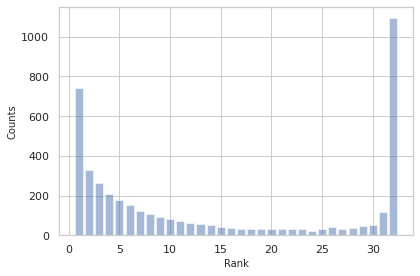

In [51]:
%autoreload
thresh=0.1
threshstr = str(thresh).replace('.','p')
nbins=32
rank = reliability.Talagrand(thresh,nbins)
#for tii in [2,3,4,5,6]:
for tii in tlist:
    volcat = aeval.volcat_avg_hash[tii]
    forecast = aeval.cdump_hash[tii]
    dfin = rank.add_data_xra(volcat,forecast)
rank.plotrank()

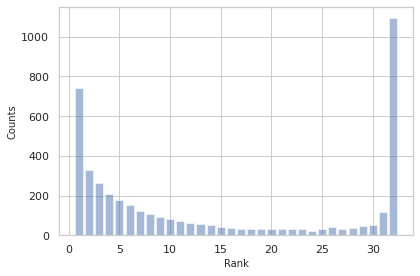

In [53]:
rank.plotrank()
plt.savefig(gdir + 'rank_{}_t{}_thresh{}'.format(tag,rel_time_str,threshstr))

In [162]:
forecast[0]

<xarray.DataArray (ens: 31, y: 34, x: 39)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * y          (y) int64 433 434 435 436 437 438 439 ... 461 462 463 464 465 466
  * x          (x) int64 877 878 879 880 881 882 883 ... 910 911 912 913 914 915
    longitude  (y, x) float64 158.2 158.3 158.4 158.5 ... 161.8 161.9 162.0
    latitude   (y, x) float64 54.18 54.18 54.18 54.18 ... 57.48 57.48 57.48
    source     <U2 'M4'
    time       datetime64[ns] 2020-10-21T22:00:00
  * ens        (ens) object 'gep01' 'gep02' 'gep03' ... 'gep29' 'gep30' 'gec00'

In [163]:
tii=8
volcat = aeval.volcat_avg_hash[tii]
forecast = aeval.cdump_hash[tii]

In [158]:
from utilhysplit.evaluation import cdf_matching

In [159]:
%autoreload

In [176]:
rfc = forecast.isel(ens=1).values.flatten()
robs = volcat.values.flatten()

In [177]:
print(len(rfc))
print(len(robs))

6674
6674


In [193]:
rfc = np.array([0,1,2,3,4])
robs = 2*rfc + 1

rfit = cdf_matching.apply_polyfit(rfc,robs)

[2. 1.]


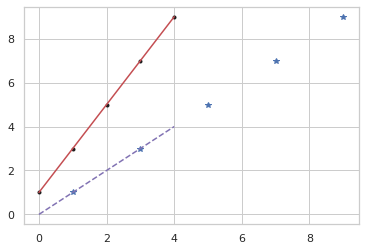

In [197]:
plt.plot(rfc,robs,'k.')
x = np.array([0,1,2,3,4])
y = rfit[0]*x + rfit[1]
plt.plot(x,y,'-r')
print(rfit)
plt.plot(rfc*rfit[0]+rfit[1],robs, 'b*')
plt.plot(x,x,'--m')

# For testing CalcScores functions

In [ ]:
%autoreload
testscores = plume_stat.CalcScores(volcat.fillna(0),forecast.fillna(0),threshold=0.1,probabilistic=False)
tframe = testscores.get_contingency_table(multi=True)

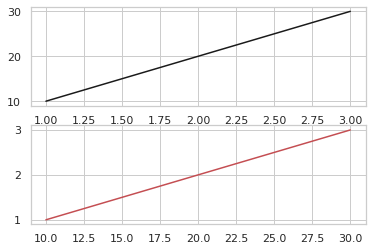

In [42]:
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
x = [1,2,3]
y = [10,20,30]
ax1.plot(x,y,'-k')
ax2.plot(y,x,'-r')

plt.show()